# Cell 0 - Accumulation Signal Sandbox
Explore alternate short-signal formulas using daily_metrics data (read-only). No database writes.

In [68]:
# Cell 1 - Imports and Configuration
from pathlib import Path
import sys

import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

project_root = Path.cwd()
if (project_root / 'darkpool_analysis').exists():
    sys.path.insert(0, str(project_root))
elif (project_root.parent / 'darkpool_analysis').exists():
    sys.path.insert(0, str(project_root.parent))
elif (project_root.parent.parent / 'darkpool_analysis').exists():
    sys.path.insert(0, str(project_root.parent.parent))

from darkpool_analysis.config import load_config, DAILY_EXPIRATION_TICKERS

config = load_config()

# =============================================================================
# TICKER CONFIGURATION
# =============================================================================
# By default, uses config.py's TICKERS_TYPE (shared with main.py)
# Set TICKERS_OVERRIDE to a list to override, e.g., ["SPY", "QQQ", "KRE"]
TICKERS_OVERRIDE = ["META"]  # None = use config.tickers

# =============================================================================
# DATE CONFIGURATION  
# =============================================================================
START_DATE = '2025-12-01'
END_DATE = 'Today'  # 'Today' or 'YYYY-MM-DD' format

# =============================================================================
# OUTPUT CONFIGURATION
# =============================================================================
OUTPUT_BASE_DIR = config.output_dir / 'WTD_VWBR'
DB_PATH = config.db_path

# =============================================================================
# BUY/SELL SIGNAL CONFIGURATION
# =============================================================================
BUY_SELL_SIGNAL = 'Rolling_Zscore'  # 'Mean_Threshold' or 'Rolling_Zscore'

# Median-threshold settings
THRESHOLD_K = 1.0       # default 1.0
THRESHOLD_K_NEG = 1.0   # default 1.0

# Rolling Z-score settings (used when BUY_SELL_SIGNAL = 'Rolling_Zscore')
ROLLING_LOOKBACK_DAYS = 20  # extra history (days) to fetch for rolling calcs
ROLLING_WINDOW_DAYS = 20
ZSCORE_K_BUY = 1.1      # default 1.1, yearly runner up 1.8 
ZSCORE_K_SELL = 1.1     # deafault 1.4, yearly runner up 1.5
ZSCORE_MIN_PERIODS = 0  # defaults to ROLLING_WINDOW_DAYS

# Rolling mean line settings (used when BUY_SELL_SIGNAL = 'Rolling_Zscore')
ROLLING_MEAN_WINDOW_DAYS = ROLLING_WINDOW_DAYS
ROLLING_MEAN_SHIFT_DAYS = 1  # use prior days for forward-valid mean

# =============================================================================
# OPTIONS PREMIUM CONFIGURATION
# =============================================================================
# Display modes: "TOTAL", "WTD_STYLE", "FULL_BREAKDOWN"
# - TOTAL: Total call/put premium bars (backwards compatible)
# - WTD_STYLE: OTM focus with ITM call hedge warning markers
# - FULL_BREAKDOWN: Stacked bars showing OTM/ITM x Call/Put
OPTIONS_PREMIUM_DISPLAY_MODE = "FULL_BREAKDOWN"

# Enable/disable options premium panels
SHOW_0DTE_PANEL = True   # Only shows for tickers in DAILY_EXPIRATION_TICKERS
SHOW_WEEKLY_PANEL = True

# ITM call hedge warning threshold (used in WTD_STYLE mode)
ITM_CALL_HEDGE_THRESHOLD = 0.30  # 30%

# =============================================================================
# PLOT DISPLAY SETTINGS
# =============================================================================
# Text scaling for 30 days
AUTO_TEXT_SCALE = True  # scale text with figure width
BASE_FIG_WIDTH = 12.0
TEXT_SCALE_MIN = 1.0
TEXT_SCALE_MAX = 3.5
TEXT_SCALE_POWER = 6  # exponent for width-based scaling

# X-axis labeling
MAX_X_LABELS = 90  # keep all labels up to this count

# Figure sizing
FIG_HEIGHT_RATIO = 1.0  # height = width * ratio
FIG_DPI = 100
FIGSIZE_PX = None  # None, or (width_px, height_px) to override

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================
def get_tickers(tickers_override: list | None = None) -> list:
    """Get tickers from config or use override if provided."""
    if tickers_override:
        return tickers_override
    return config.tickers

def parse_end_date(end_date_str: str) -> str:
    """Parse END_DATE, supporting 'Today' keyword."""
    if end_date_str.lower() == 'today':
        return pd.Timestamp.now().strftime('%Y-%m-%d')
    return end_date_str

def get_output_dir(base_dir: Path, end_date: str) -> Path:
    """Create and return dated output directory."""
    date_str = pd.to_datetime(end_date).strftime('%Y-%m-%d')
    output_dir = base_dir / date_str
    output_dir.mkdir(parents=True, exist_ok=True)
    return output_dir

# Resolve configuration
TICKERS = get_tickers(TICKERS_OVERRIDE)
END_DATE_RESOLVED = parse_end_date(END_DATE)
OUTPUT_DIR = get_output_dir(OUTPUT_BASE_DIR, END_DATE_RESOLVED)

print(f"Tickers to process: {TICKERS}")
print(f"Date range: {START_DATE} to {END_DATE_RESOLVED}")
print(f"Output directory: {OUTPUT_DIR}")

Tickers to process: ['META']
Date range: 2025-12-01 to 2026-01-24
Output directory: C:\Users\fvign\Dropbox\Vscode\darkpool\darkpool_analysis\output\WTD_VWBR\2026-01-24


In [69]:
# Cell 2 - Styling Constants and Helper Functions
import matplotlib.dates as mdates
import math
from scipy.interpolate import PchipInterpolator
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D

COLORS = {
    'background': '#0f0f10',
    'panel_bg': '#141416',
    'text': '#e6e6e6',
    'text_muted': '#8b8b8b',
    'grid': '#2a2a2d',
    'white': '#ffffff',
    'green': '#00ff88',
    'red': '#ff6b6b',
    'yellow': '#ffd700',
    'cyan': '#00d4ff',
    'orange': '#ff9f43',
    'purple': '#b026ff',
    'neutral': '#6b6b6b',
    'blue': '#4aa3ff',
    # Options premium colors (TOS style)
    'call_premium': '#6478c8',   # Steel blue
    'put_premium': '#cc0000',    # Deep red
    # ITM/OTM breakdown colors - Bullish/Bearish interpretation
    # Cyan/Teal tones = Bullish pressure, Red/Orange tones = Bearish pressure
    'otm_call': '#00BFFF',       # Cyan - OTM Calls (Bullish speculation)
    'itm_call': '#FF6B35',       # Orange - ITM Calls (Bearish hedge signal)
    'otm_put': '#FF4444',        # Red - OTM Puts (Bearish speculation)
    'itm_put': '#00CED1',        # Teal - ITM Puts (Bullish - sold protective puts)
    'hedge_warning': '#ffd700',  # Yellow for ITM call hedge warning
}
GRID_ALPHA = 0.18
OHLC_LINE_WIDTH = 1.2


def _compute_fig_width(day_count):
    if day_count <= 0:
        return 12.0
    buckets = int(np.ceil(day_count / 50))
    return 12.0 * max(1, buckets)


def _apply_axis_style(ax):
    scale = globals().get('TEXT_SCALE', 1.0)
    ax.set_facecolor(COLORS['panel_bg'])
    ax.tick_params(colors=COLORS['text'], labelsize=9 * scale)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(COLORS['grid'])
    ax.spines['bottom'].set_color(COLORS['grid'])
    ax.grid(True, alpha=GRID_ALPHA, color=COLORS['grid'], linestyle='--')


def _apply_accum_axis_style(ax):
    scale = globals().get('TEXT_SCALE', 1.0)
    ax.set_facecolor(COLORS['panel_bg'])
    ax.tick_params(colors=COLORS['text'], labelsize=9 * scale)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(COLORS['grid'])
    ax.spines['bottom'].set_color(COLORS['grid'])
    ax.grid(True, axis='y', alpha=GRID_ALPHA, color=COLORS['grid'], linestyle='-')
    ax.grid(False, axis='x')


def _apply_options_axis_style(ax):
    """Apply axis styling for options premium panel."""
    scale = globals().get('TEXT_SCALE', 1.0)
    ax.set_facecolor(COLORS['panel_bg'])
    ax.tick_params(colors=COLORS['text'], labelsize=9 * scale)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(COLORS['grid'])
    ax.spines['bottom'].set_color(COLORS['grid'])
    ax.grid(True, axis='y', alpha=GRID_ALPHA, color=COLORS['grid'], linestyle='--')
    ax.grid(False, axis='x')


def _format_plain_int(value):
    if pd.isna(value):
        return 'NA'
    return f'{value:,.0f}'.replace(',', '')


def _plot_smooth_line(ax, x_values, values, color, valid_mask, linewidth=1.0, alpha=0.7, zorder=3, linestyle='-'):
    """Plot a smooth PCHIP-interpolated line through valid data points."""
    mask = np.asarray(valid_mask)
    if mask.sum() >= 3:
        valid_x = x_values[mask]
        valid_values = values[mask]

        if pd.api.types.is_datetime64_any_dtype(valid_x):
            x_nums = mdates.date2num(pd.to_datetime(valid_x))
            x_dense = np.linspace(x_nums.min(), x_nums.max(), 150)
            x_smooth = np.unique(np.concatenate([x_nums, x_dense]))
            interp = PchipInterpolator(x_nums, np.asarray(valid_values, dtype=float))
            y_smooth = interp(x_smooth)
            x_plot = mdates.num2date(x_smooth)
        else:
            x_nums = np.asarray(valid_x, dtype=float)
            x_dense = np.linspace(x_nums.min(), x_nums.max(), 150)
            x_smooth = np.unique(np.concatenate([x_nums, x_dense]))
            interp = PchipInterpolator(x_nums, np.asarray(valid_values, dtype=float))
            y_smooth = interp(x_smooth)
            x_plot = x_smooth

        ax.plot(
            x_plot,
            y_smooth,
            color=color,
            linewidth=linewidth,
            alpha=alpha,
            zorder=zorder,
            linestyle=linestyle,
        )
    else:
        ax.plot(
            x_values[mask],
            values[mask],
            color=color,
            linewidth=linewidth,
            alpha=alpha,
            zorder=zorder,
            linestyle=linestyle,
        )


def _nice_volume_ticks(max_val, target_ticks=6):
    if max_val is None or max_val <= 0 or not np.isfinite(max_val):
        return np.array([0.0, 1.0])
    raw_step = max_val / max(target_ticks - 1, 1)
    magnitude = 10 ** int(math.floor(math.log10(raw_step)))
    while raw_step < magnitude:
        magnitude /= 10
    steps = [1, 2, 5, 10]
    step = steps[0] * magnitude
    for s in steps:
        candidate = s * magnitude
        if candidate <= raw_step:
            step = candidate
    top = math.ceil(max_val / step) * step
    return np.arange(0, top + step, step)


def _plot_ohlc_bars(ax, df_ohlc, x_indices):
    """Plot OHLC bars matching plotter_chart.py style."""
    bar_width = 0.6
    half_width = bar_width / 2

    for xi, (_, row) in zip(x_indices, df_ohlc.iterrows()):
        open_ = row['open']
        high = row['high']
        low = row['low']
        close = row['close']
        if pd.isna(open_) or pd.isna(close) or pd.isna(high) or pd.isna(low):
            continue
        color = COLORS['blue'] if close >= open_ else COLORS['orange']
        ax.vlines(xi, low, high, color=color, linewidth=OHLC_LINE_WIDTH, zorder=3)
        ax.hlines(open_, xi - half_width, xi, color=color, linewidth=OHLC_LINE_WIDTH, zorder=3)
        ax.hlines(close, xi, xi + half_width, color=color, linewidth=OHLC_LINE_WIDTH, zorder=3)


def _draw_directional_gauge(ax, directional_score: float, max_range: float = 100.0) -> None:
    """
    Draw a horizontal bullish/bearish gauge in the top-left corner.

    Args:
        ax: matplotlib axis
        directional_score: The computed score (positive=bullish, negative=bearish)
        max_range: Maximum absolute value for the gauge scale
    """
    # Clamp score to range
    clamped_score = max(-max_range, min(max_range, directional_score))
    normalized = clamped_score / max_range  # -1 to +1

    # Gauge dimensions (in axes coordinates)
    gauge_left = 0.02
    gauge_bottom = 0.82
    gauge_width = 0.22
    gauge_height = 0.10

    # Draw gauge background (gradient from red to green)
    # Left half (bearish - red)
    ax.add_patch(Rectangle(
        (gauge_left, gauge_bottom), gauge_width/2, gauge_height,
        transform=ax.transAxes, facecolor='#FF4444', alpha=0.3,
        edgecolor='none', zorder=10
    ))
    # Right half (bullish - green)
    ax.add_patch(Rectangle(
        (gauge_left + gauge_width/2, gauge_bottom), gauge_width/2, gauge_height,
        transform=ax.transAxes, facecolor='#00FF88', alpha=0.3,
        edgecolor='none', zorder=10
    ))

    # Draw gauge border
    ax.add_patch(Rectangle(
        (gauge_left, gauge_bottom), gauge_width, gauge_height,
        transform=ax.transAxes, facecolor='none',
        edgecolor=COLORS.get('grid', '#2a2a2d'), linewidth=1, zorder=11
    ))

    # Draw center line
    center_x = gauge_left + gauge_width/2
    ax.plot([center_x, center_x], [gauge_bottom, gauge_bottom + gauge_height],
            transform=ax.transAxes, color=COLORS.get('text', '#e6e6e6'),
            linewidth=1, zorder=12)

    # Draw marker/needle position
    marker_x = gauge_left + gauge_width/2 + (normalized * gauge_width/2)
    marker_color = '#00FF88' if directional_score >= 0 else '#FF4444'
    ax.plot(marker_x, gauge_bottom + gauge_height/2, 'o',
            transform=ax.transAxes, color=marker_color,
            markersize=8, markeredgecolor='white', markeredgewidth=1, zorder=13)

    # Draw score label
    label = f"{directional_score:+.1f}M"
    ax.text(marker_x, gauge_bottom - 0.02, label,
            transform=ax.transAxes, fontsize=8,
            ha='center', va='top', color=marker_color, fontweight='bold', zorder=13)

    # Draw gauge labels
    ax.text(gauge_left, gauge_bottom + gauge_height + 0.01, "Bearish",
            transform=ax.transAxes, fontsize=6, ha='left', va='bottom',
            color='#FF4444', zorder=13)
    ax.text(gauge_left + gauge_width, gauge_bottom + gauge_height + 0.01, "Bullish",
            transform=ax.transAxes, fontsize=6, ha='right', va='bottom',
            color='#00FF88', zorder=13)


In [70]:
# Cell 3 - Data Loading Functions

def fetch_options_premium_data(
    ticker: str,
    start_date: str,
    end_date: str,
    db_path: Path,
    expiration_type: str,
) -> pd.DataFrame:
    """Fetch options premium summary data for a ticker and expiration type.
    
    Args:
        ticker: Stock symbol
        start_date: Start date (YYYY-MM-DD)
        end_date: End date (YYYY-MM-DD)
        db_path: Path to DuckDB database
        expiration_type: "0DTE" or "WEEKLY"
        
    Returns:
        DataFrame with columns: date, total_call_premium, total_put_premium,
        net_premium, log_ratio, otm_call_premium, itm_call_premium,
        otm_put_premium, itm_put_premium, directional_score
    """
    query = """
        SELECT
            trade_date AS date,
            total_call_premium,
            total_put_premium,
            net_premium,
            log_ratio,
            strikes_count,
            otm_call_premium,
            itm_call_premium,
            otm_put_premium,
            itm_put_premium,
            directional_score
        FROM options_premium_summary
        WHERE symbol = ? AND trade_date BETWEEN ? AND ? AND expiration_type = ?
        ORDER BY trade_date
    """
    try:
        with duckdb.connect(str(db_path), read_only=True) as conn:
            df = conn.execute(query, [ticker.upper(), start_date, end_date, expiration_type]).df()
    except Exception as e:
        print(f"  Warning: Could not fetch {expiration_type} options data for {ticker}: {e}")
        return pd.DataFrame()
    
    if not df.empty:
        df['date'] = pd.to_datetime(df['date'])
        numeric_cols = [
            'total_call_premium', 'total_put_premium', 'net_premium', 'log_ratio',
            'otm_call_premium', 'itm_call_premium', 'otm_put_premium', 'itm_put_premium',
            'directional_score'
        ]
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
    return df


def load_ticker_data(ticker: str, start_date: str, end_date: str, db_path: Path,
                     rolling_lookback_days: int = 0,
                     fetch_options: bool = True) -> tuple:
    """Load metrics, OHLC, and options premium data for a single ticker.
    
    Args:
        ticker: Stock symbol
        start_date: Start date (YYYY-MM-DD)
        end_date: End date (YYYY-MM-DD)
        db_path: Path to DuckDB database
        rolling_lookback_days: Extra days to fetch for rolling calculations
        fetch_options: Whether to fetch options premium data
        
    Returns:
        tuple: (df, df_ohlc, options_0dte_df, options_weekly_df) DataFrames
    """
    query_start_date = start_date
    if rolling_lookback_days and int(rolling_lookback_days) > 0:
        query_start_date = (pd.to_datetime(start_date) - pd.Timedelta(days=int(rolling_lookback_days))).strftime('%Y-%m-%d')

    query = '''
        SELECT
            date,
            symbol,
            finra_buy_volume,
            short_sell_volume,
            short_buy_sell_ratio,
            short_buy_sell_ratio_z,
            lit_buy_volume,
            lit_sell_volume,
            lit_flow_imbalance,
            lit_flow_imbalance_z,
            return_z,
            otc_participation_z,
            confidence
        FROM daily_metrics
        WHERE symbol = ? AND date BETWEEN ? AND ?
        ORDER BY date
    '''

    ohlc_query = '''
        SELECT
            trade_date AS date,
            open,
            high,
            low,
            close,
            volume
        FROM polygon_daily_agg_raw
        WHERE symbol = ? AND trade_date BETWEEN ? AND ?
        ORDER BY trade_date
    '''

    with duckdb.connect(str(db_path), read_only=True) as conn:
        df = conn.execute(query, [ticker.upper(), query_start_date, end_date]).df()
        df_ohlc = conn.execute(ohlc_query, [ticker.upper(), query_start_date, end_date]).df()

    if df.empty:
        raise ValueError(f'No data found for {ticker} between {start_date} and {end_date}.')

    df['date'] = pd.to_datetime(df['date'])
    if 'finra_buy_volume' in df.columns:
        df['finra_buy_volume'] = pd.to_numeric(df['finra_buy_volume'], errors='coerce')

    # Process OHLC data
    if not df_ohlc.empty:
        df_ohlc['date'] = pd.to_datetime(df_ohlc['date'])
        for col in ['open', 'high', 'low', 'close', 'volume']:
            if col in df_ohlc.columns:
                df_ohlc[col] = pd.to_numeric(df_ohlc[col], errors='coerce')
        # Merge OHLC with metrics on date
        df = df.merge(df_ohlc, on='date', how='left')
    else:
        df['open'] = np.nan
        df['high'] = np.nan
        df['low'] = np.nan
        df['close'] = np.nan
        df['volume'] = np.nan
    
    # Fetch options premium data
    options_0dte_df = pd.DataFrame()
    options_weekly_df = pd.DataFrame()
    
    if fetch_options:
        # Check if ticker supports 0DTE (indices only)
        if ticker.upper() in DAILY_EXPIRATION_TICKERS:
            options_0dte_df = fetch_options_premium_data(
                ticker, start_date, end_date, db_path, "0DTE"
            )
        # All tickers can have weekly options
        options_weekly_df = fetch_options_premium_data(
            ticker, start_date, end_date, db_path, "WEEKLY"
        )
    
    return df, df_ohlc, options_0dte_df, options_weekly_df


def prepare_plot_data(df: pd.DataFrame, start_date: str, end_date: str) -> tuple:
    """Prepare data for plotting by filtering to date range and setting up masks.
    
    Args:
        df: Full DataFrame with metrics and OHLC
        start_date: Plot start date (YYYY-MM-DD)
        end_date: Plot end date (YYYY-MM-DD)
        
    Returns:
        tuple: (full_df, plot_df) DataFrames for full data and plot range
    """
    full_df = df.sort_values('date').copy()
    market_mask = full_df['close'].notna()
    full_df = full_df.loc[market_mask].copy()
    
    if full_df.empty:
        raise ValueError('No market days with OHLC data in the selected range.')
    
    plot_start = pd.to_datetime(start_date)
    plot_end = pd.to_datetime(end_date)
    plot_df = full_df[(full_df['date'] >= plot_start) & (full_df['date'] <= plot_end)].copy()
    plot_df = plot_df.reset_index(drop=True)
    
    if plot_df.empty:
        raise ValueError('No market days with OHLC data in the selected range.')
    
    if 'finra_buy_volume' not in plot_df.columns:
        raise ValueError('finra_buy_volume missing from dataset.')
    
    full_df['vw_accum'] = pd.to_numeric(full_df['finra_buy_volume'], errors='coerce')
    plot_df['vw_accum'] = pd.to_numeric(plot_df['finra_buy_volume'], errors='coerce')
    
    return full_df, plot_df

In [71]:
# Cell 3b - Signal Computation and Plotting Functions

def _compute_signal_indices(accum_series, valid_mask_series, full_accum_series=None,
                           full_valid_mask=None, plot_dates=None, signal_config=None):
    """Compute buy/sell signal indices based on configuration."""
    if signal_config is None:
        signal_config = {}

    buy_sell_signal = signal_config.get('buy_sell_signal', BUY_SELL_SIGNAL)
    threshold_k = signal_config.get('threshold_k', THRESHOLD_K)
    threshold_k_neg = signal_config.get('threshold_k_neg', THRESHOLD_K_NEG)
    rolling_window_days = signal_config.get('rolling_window_days', ROLLING_WINDOW_DAYS)
    zscore_k_buy = signal_config.get('zscore_k_buy', ZSCORE_K_BUY)
    zscore_k_sell = signal_config.get('zscore_k_sell', ZSCORE_K_SELL)
    zscore_min_periods = signal_config.get('zscore_min_periods', ZSCORE_MIN_PERIODS)

    if buy_sell_signal == 'Mean_Threshold':
        mean_val = accum_series[valid_mask_series].mean()
        std_val = accum_series[valid_mask_series].std(ddof=0)

        pos_threshold = mean_val + (threshold_k * std_val if std_val and std_val > 0 else 0.0)
        pos_idx = accum_series[valid_mask_series][accum_series[valid_mask_series] >= pos_threshold].index
        if len(pos_idx) == 0:
            top_n = min(5, len(accum_series[valid_mask_series]))
            pos_idx = accum_series[valid_mask_series].nlargest(top_n).index

        neg_threshold = mean_val - (threshold_k_neg * std_val if std_val and std_val > 0 else 0.0)
        neg_idx = accum_series[valid_mask_series][accum_series[valid_mask_series] <= neg_threshold].index
        if len(neg_idx) == 0:
            bottom_n = min(5, len(accum_series[valid_mask_series]))
            neg_idx = accum_series[valid_mask_series].nsmallest(bottom_n).index

        return pos_idx, neg_idx, mean_val, None

    if buy_sell_signal == 'Rolling_Zscore':
        base_series = full_accum_series if full_accum_series is not None else accum_series
        base_valid = full_valid_mask if full_valid_mask is not None else valid_mask_series
        window = int(rolling_window_days)
        min_periods = window if zscore_min_periods is None or zscore_min_periods == 0 else int(zscore_min_periods)
        prior = base_series.shift(1)
        rolling_mean = prior.rolling(window=window, min_periods=min_periods).mean()
        rolling_std = prior.rolling(window=window, min_periods=min_periods).std(ddof=0)
        z_scores = (base_series - rolling_mean) / rolling_std
        ok_mask = base_valid & rolling_mean.notna() & rolling_std.notna() & (rolling_std > 0)
        pos_mask = ok_mask & (z_scores >= zscore_k_buy)
        neg_mask = ok_mask & (z_scores <= -zscore_k_sell)
        pos_dates = base_series[pos_mask].index
        neg_dates = base_series[neg_mask].index
        if plot_dates is not None:
            pos_idx = plot_dates.index[plot_dates.isin(pos_dates)]
            neg_idx = plot_dates.index[plot_dates.isin(neg_dates)]
        else:
            pos_idx = pos_dates
            neg_idx = neg_dates
        return pos_idx, neg_idx, None, rolling_mean

    raise ValueError(f"Unknown BUY_SELL_SIGNAL mode: {buy_sell_signal}")


def _plot_options_premium(ax, prem_df, plot_dates, plot_df, display_mode="FULL_BREAKDOWN",
                         itm_call_hedge_threshold=0.30):
    """Plot options premium as asymmetrical histogram with configurable display modes."""
    if prem_df is None or prem_df.empty:
        return

    aligned_df = pd.DataFrame({'date': plot_dates})
    aligned_df = aligned_df.merge(prem_df, on='date', how='left')

    has_itm_otm = 'otm_call_premium' in aligned_df.columns and aligned_df['otm_call_premium'].notna().any()

    if display_mode == "TOTAL" or not has_itm_otm:
        call_vals = aligned_df['total_call_premium'].fillna(0).to_numpy()
        put_vals = aligned_df['total_put_premium'].fillna(0).to_numpy()
        otm_call_vals = None
        itm_call_vals = None
        otm_put_vals = None
        itm_put_vals = None
    elif display_mode == "WTD_STYLE":
        otm_call_vals = aligned_df['otm_call_premium'].fillna(0).to_numpy()
        itm_call_vals = aligned_df['itm_call_premium'].fillna(0).to_numpy()
        call_vals = otm_call_vals
        put_vals = aligned_df['total_put_premium'].fillna(0).to_numpy()
        otm_put_vals = None
        itm_put_vals = None
    elif display_mode == "FULL_BREAKDOWN":
        otm_call_vals = aligned_df['otm_call_premium'].fillna(0).to_numpy()
        itm_call_vals = aligned_df['itm_call_premium'].fillna(0).to_numpy()
        otm_put_vals = aligned_df['otm_put_premium'].fillna(0).to_numpy()
        itm_put_vals = aligned_df['itm_put_premium'].fillna(0).to_numpy()
        call_vals = otm_call_vals + itm_call_vals
        put_vals = otm_put_vals + itm_put_vals
    else:
        call_vals = aligned_df['total_call_premium'].fillna(0).to_numpy()
        put_vals = aligned_df['total_put_premium'].fillna(0).to_numpy()
        otm_call_vals = None
        itm_call_vals = None
        otm_put_vals = None
        itm_put_vals = None

    x_vals = np.arange(len(plot_df))
    bar_width = 0.7

    if display_mode == "FULL_BREAKDOWN" and otm_call_vals is not None:
        ax.bar(x_vals, otm_call_vals, width=bar_width, color=COLORS['otm_call'], alpha=0.85, label='OTM Call', zorder=3)
        ax.bar(x_vals, itm_call_vals, width=bar_width, bottom=otm_call_vals, color=COLORS['itm_call'], alpha=0.85, label='ITM Call', zorder=3)
        ax.bar(x_vals, -otm_put_vals, width=bar_width, color=COLORS['otm_put'], alpha=0.85, label='OTM Put', zorder=3)
        ax.bar(x_vals, -itm_put_vals, width=bar_width, bottom=-otm_put_vals, color=COLORS['itm_put'], alpha=0.85, label='ITM Put', zorder=3)
    elif display_mode == "WTD_STYLE" and otm_call_vals is not None:
        ax.bar(x_vals, otm_call_vals, width=bar_width, color=COLORS['otm_call'], alpha=0.85, label='OTM Call', zorder=3)
        ax.bar(x_vals, -put_vals, width=bar_width, color=COLORS['otm_put'], alpha=0.85, label='Put', zorder=3)
    else:
        ax.bar(x_vals, call_vals, width=bar_width, color=COLORS['green'], alpha=0.85, label='Call', zorder=3)
        ax.bar(x_vals, -put_vals, width=bar_width, color=COLORS['red'], alpha=0.85, label='Put', zorder=3)

    ax.axhline(y=0, color=COLORS['neutral'], linestyle='--', linewidth=0.8, alpha=0.6, zorder=1)

    if display_mode == 'WTD_STYLE' and itm_call_vals is not None:
        for i, (otm, itm) in enumerate(zip(otm_call_vals, itm_call_vals)):
            total = otm + itm
            if total > 0 and itm / total >= itm_call_hedge_threshold:
                ax.plot(i, call_vals[i] * 1.05, marker='v', color=COLORS['yellow'], markersize=6, zorder=5)
    elif display_mode == 'FULL_BREAKDOWN':
        pass


def plot_wtd_vwbr(ticker: str, full_df: pd.DataFrame, plot_df: pd.DataFrame,
                  start_date: str, end_date: str, output_dir: Path,
                  signal_config: dict = None, plot_config: dict = None,
                  options_0dte_df: pd.DataFrame = None,
                  options_weekly_df: pd.DataFrame = None,
                  options_display_mode: str = "FULL_BREAKDOWN",
                  show_0dte_panel: bool = True,
                  show_weekly_panel: bool = True,
                  itm_call_hedge_threshold: float = 0.30) -> tuple:
    """Generate WTD VWBR plot for a single ticker.
    
    Args:
        ticker: Stock ticker symbol
        full_df: Full DataFrame with historical data
        plot_df: Filtered DataFrame for plot range
        start_date: Start date string
        end_date: End date string
        output_dir: Output directory path
        signal_config: Signal calculation parameters
        plot_config: Plot display parameters
        options_0dte_df: 0DTE options premium DataFrame (optional)
        options_weekly_df: Weekly options premium DataFrame (optional)
        options_display_mode: "TOTAL", "WTD_STYLE", or "FULL_BREAKDOWN"
        show_0dte_panel: Whether to show 0DTE options panel
        show_weekly_panel: Whether to show weekly options panel
        itm_call_hedge_threshold: Threshold for ITM call hedge warning markers
        
    Returns:
        tuple: (fig, report_df) matplotlib Figure and signal report DataFrame
    """
    if signal_config is None:
        signal_config = {
            'buy_sell_signal': BUY_SELL_SIGNAL,
            'threshold_k': THRESHOLD_K,
            'threshold_k_neg': THRESHOLD_K_NEG,
            'rolling_window_days': ROLLING_WINDOW_DAYS,
            'zscore_k_buy': ZSCORE_K_BUY,
            'zscore_k_sell': ZSCORE_K_SELL,
            'zscore_min_periods': ZSCORE_MIN_PERIODS,
            'rolling_mean_window_days': ROLLING_MEAN_WINDOW_DAYS,
            'rolling_mean_shift_days': ROLLING_MEAN_SHIFT_DAYS,
        }
    
    if plot_config is None:
        plot_config = {
            'auto_text_scale': AUTO_TEXT_SCALE,
            'base_fig_width': BASE_FIG_WIDTH,
            'text_scale_min': TEXT_SCALE_MIN,
            'text_scale_max': TEXT_SCALE_MAX,
            'text_scale_power': TEXT_SCALE_POWER,
            'max_x_labels': MAX_X_LABELS,
            'fig_height_ratio': FIG_HEIGHT_RATIO,
            'fig_dpi': FIG_DPI,
            'figsize_px': FIGSIZE_PX,
        }

    x_labels = plot_df['date'].dt.strftime('%Y%m%d').tolist()
    accum_series = plot_df['finra_buy_volume']
    
    if accum_series.isna().all():
        raise ValueError(f'finra_buy_volume is empty for {ticker} in the selected range.')
    
    full_accum_series = full_df.set_index('date')['vw_accum']
    full_valid_mask = ~full_accum_series.isna()
    plot_dates = plot_df['date']
    valid_mask = ~plot_df['vw_accum'].isna()
    accum = plot_df['vw_accum']

    # Figure sizing
    fig_width = _compute_fig_width(len(plot_df))
    fig_height = fig_width * plot_config['fig_height_ratio']
    figsize = (fig_width, fig_height)
    if plot_config['figsize_px'] is not None:
        fig_width = plot_config['figsize_px'][0] / plot_config['fig_dpi']
        fig_height = plot_config['figsize_px'][1] / plot_config['fig_dpi']
        figsize = (fig_width, fig_height)

    text_scale = 1.0
    if plot_config['auto_text_scale']:
        base_width = float(plot_config['base_fig_width'])
        if base_width > 0:
            text_scale = (fig_width / base_width) ** plot_config['text_scale_power']
        text_scale = max(plot_config['text_scale_min'], min(plot_config['text_scale_max'], text_scale))

    plt.style.use('dark_background')
    
    # Determine panel configuration
    has_0dte = options_0dte_df is not None and not options_0dte_df.empty and show_0dte_panel
    has_weekly = options_weekly_df is not None and not options_weekly_df.empty and show_weekly_panel
    
    # Base panels: Price (1.3), FINRA Buy Volume (2)
    height_ratios = [1.3, 2]
    num_panels = 2
    
    if has_0dte:
        height_ratios.append(1.2)
        num_panels += 1
    if has_weekly:
        height_ratios.append(1.2)
        num_panels += 1
    
    fig = plt.figure(figsize=figsize)
    fig.patch.set_facecolor(COLORS['background'])
    fig_gs = fig.add_gridspec(num_panels, 1, height_ratios=height_ratios, hspace=0.15,
                              left=0.1, right=0.94, top=0.9, bottom=0.1)

    ax_price = fig.add_subplot(fig_gs[0])
    ax_accum = fig.add_subplot(fig_gs[1], sharex=ax_price)
    
    ax_0dte = None
    ax_weekly = None
    panel_idx = 2
    
    if has_0dte:
        ax_0dte = fig.add_subplot(fig_gs[panel_idx], sharex=ax_price)
        panel_idx += 1
    if has_weekly:
        ax_weekly = fig.add_subplot(fig_gs[panel_idx], sharex=ax_price)

    # Panel 1: OHLC
    _apply_axis_style(ax_price)
    x_vals = np.arange(len(plot_df))
    _plot_ohlc_bars(ax_price, plot_df, x_vals)
    ax_price.set_ylabel('Price', color=COLORS['white'], fontsize=10 * text_scale)
    ax_price.set_title('Price Action (OHLC)', color=COLORS['white'], fontsize=11 * text_scale, fontweight='bold', loc='left')
    ax_price.tick_params(axis='x', labelbottom=False)
    if len(x_vals) > 0:
        ax_price.set_xlim(x_vals.min() - 0.6, x_vals.max() + 0.6)

    # Panel 2: Accumulation
    _apply_accum_axis_style(ax_accum)
    
    if valid_mask.any():
        _plot_smooth_line(ax_accum, x_vals, accum, COLORS['green'], valid_mask, linewidth=1.4, alpha=0.9, zorder=3)
        ax_accum.scatter(x_vals[valid_mask], accum.loc[valid_mask], color=COLORS['green'], s=80, zorder=4)

    max_val = accum[valid_mask].max() if valid_mask.any() else 1.0
    if pd.isna(max_val) or max_val <= 0:
        max_val = 1.0
    
    y_min = 0.0
    y_ticks = _nice_volume_ticks(max_val * 1.1)
    ax_accum.set_ylim(y_min, float(y_ticks[-1]))
    ax_accum.set_yticks(y_ticks)
    ax_accum.grid(True, axis='y', linestyle='-', color=COLORS['grid'], alpha=0.9, linewidth=0.8)
    ax_accum.set_axisbelow(True)
    ax_accum.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: _format_plain_int(x)))
    ax_accum.tick_params(axis='y', colors=COLORS['green'])
    ax_accum.set_ylabel('FINRA Buy Volume', color=COLORS['cyan'], fontsize=12 * text_scale)
    ax_accum.tick_params(axis='x', labelbottom=False)  # Hide x-axis labels, keep tickmarks
    ax_accum.set_title('FINRA Buy Volume', color=COLORS['cyan'], fontsize=12 * text_scale, fontweight='bold', loc='center', pad=10 * text_scale)

    # Compute signals
    pos_idx, neg_idx = [], []
    if valid_mask.any():
        pos_idx, neg_idx, mean_val, rolling_mean = _compute_signal_indices(
            accum, valid_mask,
            full_accum_series=full_accum_series,
            full_valid_mask=full_valid_mask,
            plot_dates=plot_dates,
            signal_config=signal_config,
        )

        if signal_config['buy_sell_signal'] == 'Mean_Threshold' and mean_val is not None:
            ax_accum.axhline(mean_val, color=COLORS['orange'], linestyle='--', linewidth=1.0, alpha=0.8, zorder=2)

        if signal_config['buy_sell_signal'] == 'Rolling_Zscore':
            rolling_prior = full_accum_series.shift(int(signal_config['rolling_mean_shift_days']))
            rolling_mean_line_full = rolling_prior.rolling(
                window=int(signal_config['rolling_mean_window_days']),
                min_periods=int(signal_config['rolling_mean_window_days']),
            ).mean()
            rolling_mean_line = rolling_mean_line_full.reindex(plot_dates)
            rolling_mask = rolling_mean_line.notna()
            if rolling_mask.any():
                _plot_smooth_line(ax_accum, x_vals, rolling_mean_line, COLORS['orange'], rolling_mask,
                                 linewidth=1.0, alpha=0.8, zorder=2, linestyle='--')

        # Plot signal markers on price panel
        price_lows = plot_df['low'].to_numpy()
        price_highs = plot_df['high'].to_numpy()
        price_min = np.nanmin(plot_df['close'].to_numpy()) if np.isfinite(plot_df['close'].to_numpy()).any() else np.nan
        price_max = np.nanmax(plot_df['close'].to_numpy()) if np.isfinite(plot_df['close'].to_numpy()).any() else np.nan
        if np.isfinite(price_min) and np.isfinite(price_max):
            offset = (price_max - price_min) * 0.03 or 1.0
            if len(pos_idx) > 0:
                ax_price.scatter(x_vals[pos_idx], plot_df.loc[pos_idx, 'low'].to_numpy() - offset,
                                s=60, color=COLORS['green'], zorder=5)
            if len(neg_idx) > 0:
                ax_price.scatter(x_vals[neg_idx], plot_df.loc[neg_idx, 'high'].to_numpy() + offset,
                                s=60, color=COLORS['red'], zorder=5)

        # Vertical lines on accumulation panel
        for idx in pos_idx:
            ax_accum.vlines(x_vals[idx], y_min, accum.loc[idx], color="#6bd5ff", linestyle='--', linewidth=1.0, alpha=0.8, zorder=2)
        for idx in neg_idx:
            ax_accum.vlines(x_vals[idx], y_min, accum.loc[idx], color="#ff0000", linestyle='--', linewidth=1.0, alpha=0.8, zorder=2)

    # Options panels
    if ax_0dte is not None:
        _apply_options_axis_style(ax_0dte)
        _plot_options_premium(ax_0dte, options_0dte_df, plot_dates, plot_df,
                             display_mode=options_display_mode,
                             itm_call_hedge_threshold=itm_call_hedge_threshold)
        ax_0dte.set_ylabel('Premium ($)', color=COLORS['yellow'], fontsize=10 * text_scale)
        ax_0dte.set_title('0DTE Options Premium', color=COLORS['yellow'], fontsize=10 * text_scale, fontweight='bold', loc='center')
        ax_0dte.tick_params(axis='x', labelbottom=False)

    if ax_weekly is not None:
        _apply_options_axis_style(ax_weekly)
        _plot_options_premium(ax_weekly, options_weekly_df, plot_dates, plot_df,
                             display_mode=options_display_mode,
                             itm_call_hedge_threshold=itm_call_hedge_threshold)
        ax_weekly.set_ylabel('Premium ($)', color=COLORS['purple'], fontsize=10 * text_scale)
        ax_weekly.set_title('Weekly Options Premium', color=COLORS['purple'], fontsize=10 * text_scale, fontweight='bold', loc='left')

    # X-axis labels on bottom panel
    bottom_ax = ax_weekly if ax_weekly is not None else (ax_0dte if ax_0dte is not None else ax_accum)
    
    label_step = 1
    if len(x_vals) > plot_config['max_x_labels']:
        label_step = int(np.ceil(len(x_vals) / plot_config['max_x_labels']))
    x_tick_positions = x_vals[::label_step]
    x_tick_labels = x_labels[::label_step]
    if len(x_tick_positions) > 0 and x_tick_positions[-1] != x_vals[-1]:
        x_tick_positions = np.append(x_tick_positions, x_vals[-1])
        x_tick_labels.append(x_labels[-1])

    bottom_ax.set_xticks(x_tick_positions)
    bottom_ax.set_xticklabels(x_tick_labels, rotation=90, ha='center', fontsize=8 * text_scale, color=COLORS['text_muted'])
    bottom_ax.tick_params(axis='x', labelbottom=True, colors=COLORS['text_muted'])
    bottom_ax.set_xlabel('Date', color=COLORS['cyan'], fontsize=12 * text_scale)

    # Annotations
    signal_note = ''
    if signal_config['buy_sell_signal'] == 'Mean_Threshold':
        signal_note = (
            f"Signal: Mean Threshold (mean +/- k*std). k_buy={signal_config['threshold_k']:.2f}, k_sell={signal_config['threshold_k_neg']:.2f}"
        )
    elif signal_config['buy_sell_signal'] == 'Rolling_Zscore':
        min_periods = signal_config['zscore_min_periods'] if signal_config['zscore_min_periods'] else signal_config['rolling_window_days']
        signal_note = (
            f"Signal: Rolling Z-Score (window={signal_config['rolling_window_days']}, min={min_periods}, K Buy +{signal_config['zscore_k_buy']:.2f} / K Sell -{signal_config['zscore_k_sell']:.2f})"
        )

    last_update = plot_df['date'].max()
    if pd.notna(last_update):
        last_update_str = f"{last_update.month}/{last_update.day}/{last_update.year}"
    else:
        last_update_str = 'NA'

    fig.text(0.02, 0.96,
        f"{ticker}: FINRA Buy Volume",
        color=COLORS['cyan'], fontsize=16 * text_scale, fontweight='bold', ha='left', va='top')
    
    fig.text(0.98, 0.96,
        f"Last Update {last_update_str}",
        color=COLORS['white'], fontsize=11 * text_scale, ha='right', va='top')

    fig.text(0.02, 0.02, signal_note, color=COLORS['text_muted'], fontsize=8 * text_scale, ha='left', va='bottom')
    fig.text(0.94, 0.02, 'all credit to: next', color=COLORS['text_muted'], fontsize=10 * text_scale, ha='right', va='bottom')
    fig.text(0.98, 0.02, 'Signals', color=COLORS['cyan'], fontsize=10 * text_scale, ha='right', va='bottom')

    # Save figure
    start_str = pd.to_datetime(start_date).strftime('%Y-%m-%d')
    end_str = pd.to_datetime(end_date).strftime('%Y-%m-%d')
    output_path = output_dir / f"{ticker.lower()}_wtd_vwbr_{start_str}_{end_str}.png"
    fig.savefig(output_path, dpi=150, facecolor=COLORS['background'], edgecolor='none')

    # Build signal report
    buy_dates = plot_df.loc[pos_idx, 'date'] if len(pos_idx) > 0 else pd.Series(dtype='datetime64[ns]')
    sell_dates = plot_df.loc[neg_idx, 'date'] if len(neg_idx) > 0 else pd.Series(dtype='datetime64[ns]')

    report_df = pd.DataFrame({
        'date': pd.concat([buy_dates, sell_dates], ignore_index=True),
        'signal': ['BUY'] * len(buy_dates) + ['SELL'] * len(sell_dates),
    }).sort_values('date')

    return fig, report_df


def _apply_options_axis_style(ax):
    """Apply styling to options premium axis."""
    ax.set_facecolor(COLORS['panel_bg'])
    ax.tick_params(colors=COLORS['text'], labelsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(COLORS['grid'])
    ax.spines['bottom'].set_color(COLORS['grid'])
    ax.grid(True, axis='y', alpha=GRID_ALPHA, color=COLORS['grid'], linestyle='--')


Processing 1 tickers
Date range: 2025-12-01 to 2026-01-24
Output: C:\Users\fvign\Dropbox\Vscode\darkpool\darkpool_analysis\output\WTD_VWBR\2026-01-24
Options display mode: FULL_BREAKDOWN


────────────────────────────────────────
Processing: META
────────────────────────────────────────
  Weekly options data: 37 days


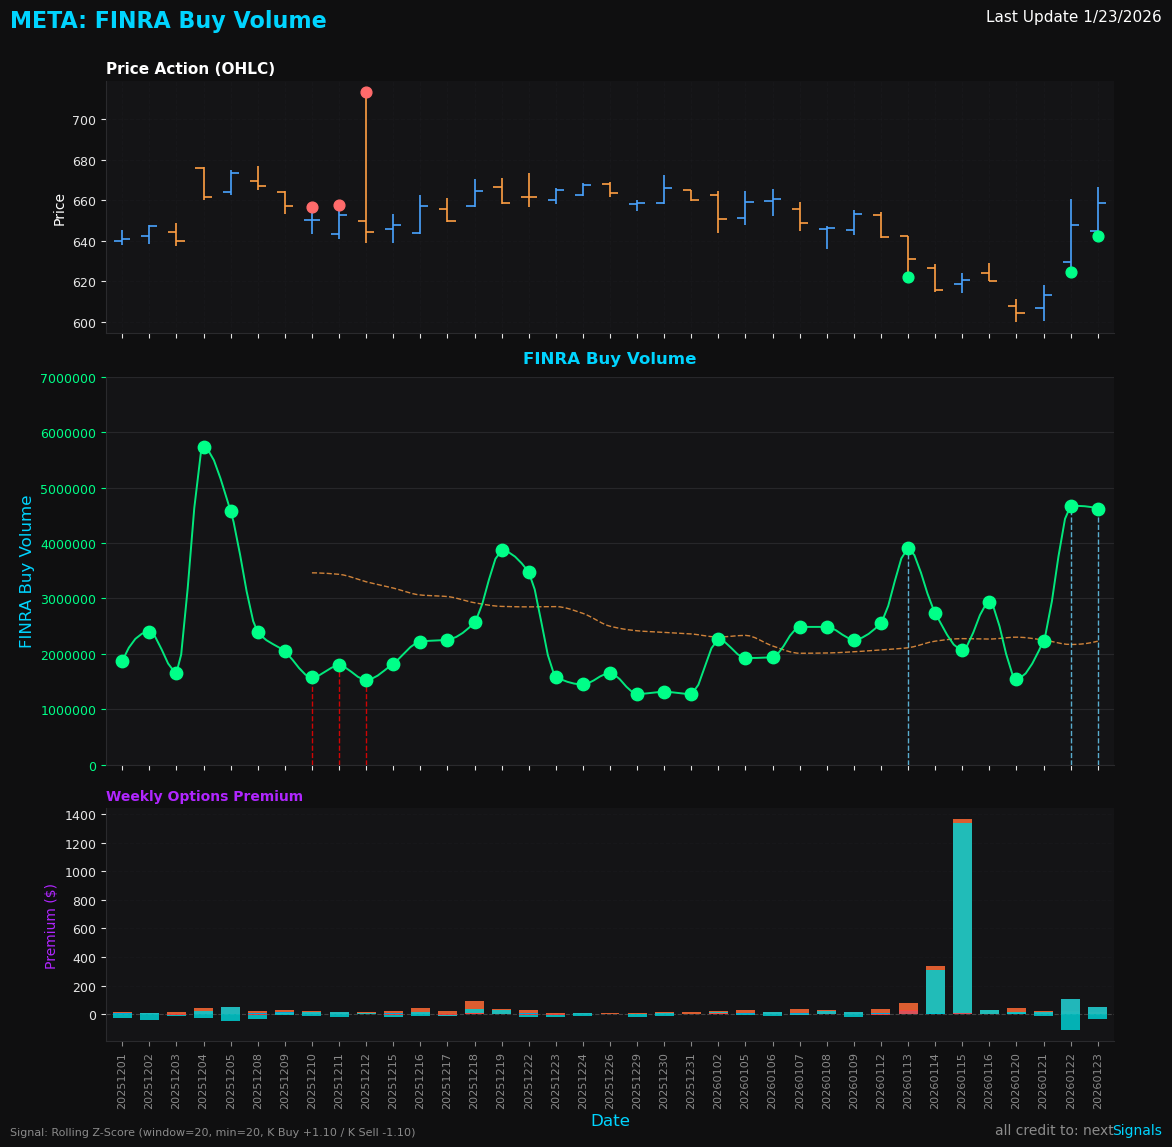

  Saved: C:\Users\fvign\Dropbox\Vscode\darkpool\darkpool_analysis\output\WTD_VWBR\2026-01-24\meta_wtd_vwbr_2025-12-01_2026-01-24.png

PROCESSING COMPLETE
Successful: 1 tickers
Failed: 0 tickers

Output saved to: C:\Users\fvign\Dropbox\Vscode\darkpool\darkpool_analysis\output\WTD_VWBR\2026-01-24


In [72]:
# =============================================================================
# MAIN LOOP - Process All Tickers
# =============================================================================
print(f"\n{'='*60}")
print(f"Processing {len(TICKERS)} tickers")
print(f"Date range: {START_DATE} to {END_DATE_RESOLVED}")
print(f"Output: {OUTPUT_DIR}")
print(f"Options display mode: {OPTIONS_PREMIUM_DISPLAY_MODE}")
print(f"{'='*60}\n")

# Build signal config from globals
signal_config = {
    'buy_sell_signal': BUY_SELL_SIGNAL,
    'threshold_k': THRESHOLD_K,
    'threshold_k_neg': THRESHOLD_K_NEG,
    'rolling_window_days': ROLLING_WINDOW_DAYS,
    'zscore_k_buy': ZSCORE_K_BUY,
    'zscore_k_sell': ZSCORE_K_SELL,
    'zscore_min_periods': ZSCORE_MIN_PERIODS,
    'rolling_mean_window_days': ROLLING_MEAN_WINDOW_DAYS,
    'rolling_mean_shift_days': ROLLING_MEAN_SHIFT_DAYS,
}

plot_config = {
    'auto_text_scale': AUTO_TEXT_SCALE,
    'base_fig_width': BASE_FIG_WIDTH,
    'text_scale_min': TEXT_SCALE_MIN,
    'text_scale_max': TEXT_SCALE_MAX,
    'text_scale_power': TEXT_SCALE_POWER,
    'max_x_labels': MAX_X_LABELS,
    'fig_height_ratio': FIG_HEIGHT_RATIO,
    'fig_dpi': FIG_DPI,
    'figsize_px': FIGSIZE_PX,
}

all_reports = []
all_data_by_ticker = {}  # Store full_df per ticker for performance analysis
successful_tickers = []
failed_tickers = []

for ticker in TICKERS:
    print(f"\n{'─'*40}")
    print(f"Processing: {ticker}")
    print(f"{'─'*40}")
    
    try:
        # Load data (including options premium)
        lookback = ROLLING_LOOKBACK_DAYS if BUY_SELL_SIGNAL == 'Rolling_Zscore' else 0
        df, df_ohlc, options_0dte_df, options_weekly_df = load_ticker_data(
            ticker, START_DATE, END_DATE_RESOLVED, DB_PATH, lookback,
            fetch_options=True
        )
        
        # Report options data availability
        if not options_0dte_df.empty:
            print(f"  0DTE options data: {len(options_0dte_df)} days")
        if not options_weekly_df.empty:
            print(f"  Weekly options data: {len(options_weekly_df)} days")
        
        # Prepare plot data
        full_df, plot_df = prepare_plot_data(df, START_DATE, END_DATE_RESOLVED)
        
        # Store full_df for performance analysis
        all_data_by_ticker[ticker] = full_df.copy()
        
        # Generate plot with options panels
        fig, report_df = plot_wtd_vwbr(
            ticker, full_df, plot_df,
            START_DATE, END_DATE_RESOLVED, OUTPUT_DIR,
            signal_config=signal_config,
            plot_config=plot_config,
            options_0dte_df=options_0dte_df,
            options_weekly_df=options_weekly_df,
            options_display_mode=OPTIONS_PREMIUM_DISPLAY_MODE,
            show_0dte_panel=SHOW_0DTE_PANEL,
            show_weekly_panel=SHOW_WEEKLY_PANEL,
            itm_call_hedge_threshold=ITM_CALL_HEDGE_THRESHOLD,
        )
        
        # Display inline
        plt.show()
        
        # Add ticker to report
        if not report_df.empty:
            report_df['ticker'] = ticker
            all_reports.append(report_df)
        
        successful_tickers.append(ticker)
        print(f"  Saved: {OUTPUT_DIR / f'{ticker.lower()}_wtd_vwbr_{START_DATE}_{END_DATE_RESOLVED}.png'}")
        
    except ValueError as e:
        print(f"  SKIPPED: {e}")
        failed_tickers.append((ticker, str(e)))
        continue
    except Exception as e:
        print(f"  ERROR: {e}")
        failed_tickers.append((ticker, str(e)))
        continue

# Summary
print(f"\n{'='*60}")
print("PROCESSING COMPLETE")
print(f"{'='*60}")
print(f"Successful: {len(successful_tickers)} tickers")
print(f"Failed: {len(failed_tickers)} tickers")
if failed_tickers:
    print("\nFailed tickers:")
    for t, err in failed_tickers:
        print(f"  - {t}: {err}")
print(f"\nOutput saved to: {OUTPUT_DIR}")

In [73]:
# Cell 5 - Combined Signal Report
if 'all_reports' not in globals() or not all_reports:
    print('No signals found across all processed tickers.')
else:
    combined_report = pd.concat(all_reports, ignore_index=True)
    combined_report = combined_report.sort_values(['date', 'ticker'])
    combined_report['date'] = combined_report['date'].dt.strftime('%Y-%m-%d')
    
    print(f"\n{'='*60}")
    print("COMBINED SIGNAL REPORT")
    print(f"{'='*60}")
    print(f"Total signals: {len(combined_report)}")
    print(f"  - BUY:  {(combined_report['signal'] == 'BUY').sum()}")
    print(f"  - SELL: {(combined_report['signal'] == 'SELL').sum()}")
    print(f"{'='*60}\n")
    
    try:
        display(combined_report[['date', 'ticker', 'signal']].reset_index(drop=True))
    except NameError:
        print(combined_report[['date', 'ticker', 'signal']].reset_index(drop=True))
    
    # Save combined report to CSV
    report_path = OUTPUT_DIR / f"signal_report_{START_DATE}_{END_DATE_RESOLVED}.csv"
    combined_report[['date', 'ticker', 'signal']].to_csv(report_path, index=False)
    print(f"\nReport saved to: {report_path}")



COMBINED SIGNAL REPORT
Total signals: 6
  - BUY:  3
  - SELL: 3



,date,ticker,signal
0,2025-12-10,META,SELL
1,2025-12-11,META,SELL
2,2025-12-12,META,SELL
3,2026-01-13,META,BUY
4,2026-01-22,META,BUY
5,2026-01-23,META,BUY



Report saved to: C:\Users\fvign\Dropbox\Vscode\darkpool\darkpool_analysis\output\WTD_VWBR\2026-01-24\signal_report_2025-12-01_2026-01-24.csv


In [74]:
# =============================================================================
# PERFORMANCE MATRIX: Signal Cluster Analysis
# =============================================================================
from collections import defaultdict
import dataframe_image as dfi

def identify_clusters(report_df, signal_type, window_days=10):
    """
    Identify clusters of same-direction signals within a rolling window.
    
    Returns list of clusters, each containing:
    - signal_dates: list of dates in cluster
    - cluster_size: number of signals
    - ticker: the ticker symbol
    """
    # Filter to signal type (BUY or SELL)
    signals = report_df[report_df['signal'] == signal_type].copy()
    if signals.empty:
        return []
    
    # Convert date to datetime if string
    if signals['date'].dtype == 'object':
        signals['date'] = pd.to_datetime(signals['date'])
    
    signals = signals.sort_values('date').reset_index(drop=True)
    
    clusters = []
    used_indices = set()
    
    for i in range(len(signals)):
        if i in used_indices:
            continue
        
        row = signals.iloc[i]
        # Find all same-direction signals within window_days of this signal
        cluster_dates = [row['date']]
        cluster_indices = [i]
        cluster_ticker = row['ticker']
        
        for j in range(i + 1, len(signals)):
            if j in used_indices:
                continue
            next_row = signals.iloc[j]
            next_date = next_row['date']
            # Check if within window_days (calendar days) of the last signal in cluster
            days_diff = (next_date - cluster_dates[-1]).days
            if days_diff <= window_days and next_row['ticker'] == cluster_ticker:
                cluster_dates.append(next_date)
                cluster_indices.append(j)
        
        # Mark all as used
        used_indices.update(cluster_indices)
        
        clusters.append({
            'signal_dates': cluster_dates,
            'cluster_size': len(cluster_dates),
            'ticker': cluster_ticker
        })
    
    return clusters


def generate_sub_clusters(cluster):
    """
    For a cluster of signals [A, B, C, ...], generate all sliding window sub-clusters.
    
    Example for cluster [A, B, C]:
    - Size 1: entries after A, B, C (3 data points for "1 signal" row)
    - Size 2: entries after B (for A,B window), after C (for B,C window) (2 data points for "2 signals" row)
    - Size 3: entry after C (for A,B,C window) (1 data point for "3 signals" row)
    
    Returns list of sub-clusters with size and entry_date.
    """
    signal_dates = cluster['signal_dates']
    ticker = cluster['ticker']
    n = len(signal_dates)
    
    sub_clusters = []
    
    for size in range(1, n + 1):
        # Slide window of 'size' across the signals
        for start in range(n - size + 1):
            window = signal_dates[start:start + size]
            entry_date = window[-1]  # Entry is after last signal in window
            sub_clusters.append({
                'size': size,
                'entry_date': entry_date,
                'ticker': ticker
            })
    
    return sub_clusters


def calculate_forward_returns(entry_date, ticker_df, max_days=30):
    """
    Calculate returns for days 1 through max_days after entry.
    Entry = next session's open after entry_date.
    Exit = close price at day N.
    
    Returns dict: {1: return_1d, 2: return_2d, ..., 30: return_30d}
    """
    # Convert entry_date to same type as ticker_df['date']
    if ticker_df['date'].dtype == 'datetime64[ns]':
        if isinstance(entry_date, str):
            entry_date = pd.to_datetime(entry_date)
    
    # Find entry index (next trading day after entry_date)
    signal_mask = ticker_df['date'] == entry_date
    if not signal_mask.any():
        return {d: np.nan for d in range(1, max_days + 1)}
    
    ticker_df_reset = ticker_df.reset_index(drop=True)
    signal_pos = ticker_df_reset[ticker_df_reset['date'] == entry_date].index[0]
    
    entry_pos = signal_pos + 1
    if entry_pos >= len(ticker_df_reset):
        return {d: np.nan for d in range(1, max_days + 1)}
    
    entry_price = ticker_df_reset.loc[entry_pos, 'open']
    if pd.isna(entry_price) or entry_price == 0:
        return {d: np.nan for d in range(1, max_days + 1)}
    
    returns = {}
    for day in range(1, max_days + 1):
        exit_pos = entry_pos + day - 1  # day 1 = same day close
        if exit_pos >= len(ticker_df_reset):
            returns[day] = np.nan
        else:
            exit_price = ticker_df_reset.loc[exit_pos, 'close']
            if pd.isna(exit_price):
                returns[day] = np.nan
            else:
                returns[day] = (exit_price - entry_price) / entry_price * 100
    
    return returns


def build_performance_matrix(clusters, all_data_by_ticker, max_days=30):
    """
    Build matrix: rows=cluster sizes, cols=forward days, values=avg returns.
    
    For each cluster, generates all sliding window sub-clusters and aggregates
    returns by window size.
    
    Example: A cluster of 3 signals [A, B, C] contributes:
    - 3 entries to "1 signal" row (after A, B, C)
    - 2 entries to "2 signals" row (after B for A-B, after C for B-C)
    - 1 entry to "3 signals" row (after C for A-B-C)
    """
    if not clusters:
        return pd.DataFrame()
    
    # Generate all sub-clusters and group by size
    returns_by_size = defaultdict(list)
    
    for cluster in clusters:
        ticker = cluster['ticker']
        
        if ticker not in all_data_by_ticker:
            continue
        
        ticker_df = all_data_by_ticker[ticker]
        
        # Generate all sliding window sub-clusters
        sub_clusters = generate_sub_clusters(cluster)
        
        for sub in sub_clusters:
            size = sub['size']
            returns = calculate_forward_returns(sub['entry_date'], ticker_df, max_days)
            returns_by_size[size].append(returns)
    
    if not returns_by_size:
        return pd.DataFrame()
    
    # Build matrix
    max_size = max(returns_by_size.keys())
    matrix_data = []
    
    for size in range(1, max_size + 1):
        if size in returns_by_size:
            # Average returns across all sub-clusters of this size
            all_returns = returns_by_size[size]
            avg_returns = {}
            for day in range(1, max_days + 1):
                day_returns = [r[day] for r in all_returns if not pd.isna(r[day])]
                avg_returns[day] = np.mean(day_returns) if day_returns else np.nan
            matrix_data.append(avg_returns)
        else:
            # No sub-clusters of this size - blank row
            matrix_data.append({d: np.nan for d in range(1, max_days + 1)})
    
    # Convert to DataFrame
    df = pd.DataFrame(matrix_data)
    df.columns = [f'{d}d' for d in range(1, max_days + 1)]
    df.index = [f'{i+1} signal{"s" if i > 0 else ""}' for i in range(len(df))]
    
    return df


def color_returns_cell_light(val):
    """Apply red-yellow-green background gradient, red/green text based on return value."""
    if pd.isna(val):
        return 'background-color: #f5f5f5; color: #cccccc'  # Light gray for N/A

    # Clamp value between -10% and +10% for gradient calculation
    clamped = max(-10, min(10, val))

    # Normalize to 0-1 range where 0 = -10%, 0.5 = 0%, 1 = +10%
    normalized = (clamped + 10) / 20

    # Red-Yellow-Green background gradient
    # Red (255,80,80) -> Yellow (255,255,100) -> Green (80,200,80)
    if normalized <= 0.5:
        # Red to Yellow (0 to 0.5)
        t = normalized * 2  # 0 to 1
        r = 255
        g = int(80 + 175 * t)  # 80 -> 255
        b = int(80 + 20 * t)   # 80 -> 100
    else:
        # Yellow to Green (0.5 to 1)
        t = (normalized - 0.5) * 2  # 0 to 1
        r = int(255 - 175 * t)  # 255 -> 80
        g = int(255 - 55 * t)   # 255 -> 200
        b = int(100 - 20 * t)   # 100 -> 80

    # Text color: Red for negative, Green for positive
    if val > 0:
        text_color = '#006400'  # Dark green
    elif val < 0:
        text_color = '#8b0000'  # Dark red
    else:
        text_color = '#333333'  # Dark gray for zero

    return f'background-color: rgb({r},{g},{b}); color: {text_color}; font-weight: bold'


def style_performance_matrix(df, title):
    """Apply full styling to performance matrix (light mode for export)."""
    if df.empty:
        return df
    
    styled = (df.style
        .map(color_returns_cell_light)
        .format(lambda x: f'{x:+.2f}%' if pd.notna(x) else '')
        .set_properties(**{
            'text-align': 'center',
            'font-size': '11px',
            'border': '1px solid #dddddd',
            'padding': '4px 8px'
        })
        .set_table_styles([
            {'selector': 'th', 'props': [
                ('background-color', '#f0f0f0'),
                ('color', '#333333'),
                ('font-weight', 'bold'),
                ('text-align', 'center'),
                ('padding', '6px 8px'),
                ('border', '1px solid #dddddd')
            ]},
            {'selector': 'th.row_heading', 'props': [
                ('background-color', '#f0f0f0'),
                ('color', '#333333'),
                ('font-weight', 'bold'),
                ('border', '1px solid #dddddd')
            ]},
            {'selector': 'caption', 'props': [
                ('color', '#333333'),
                ('font-size', '14px'),
                ('font-weight', 'bold'),
                ('padding', '10px'),
                ('background-color', '#ffffff')
            ]},
            {'selector': 'table', 'props': [
                ('border-collapse', 'collapse'),
                ('background-color', '#ffffff')
            ]}
        ])
        .set_caption(title)
    )
    return styled


def export_styled_table(styled_df, output_path):
    """Export styled DataFrame to PNG using dataframe_image."""
    try:
        dfi.export(styled_df, str(output_path), table_conversion='matplotlib')
        print(f"  Table exported to: {output_path}")
    except Exception as e:
        print(f"  Warning: Could not export table to PNG: {e}")


# Build performance matrices
if 'combined_report' in globals() and not combined_report.empty and 'all_data_by_ticker' in globals():
    # Identify clusters
    buy_clusters = identify_clusters(combined_report, 'BUY', window_days=10)
    sell_clusters = identify_clusters(combined_report, 'SELL', window_days=10)
    
    # Build matrices
    buy_matrix = build_performance_matrix(buy_clusters, all_data_by_ticker, max_days=30)
    sell_matrix = build_performance_matrix(sell_clusters, all_data_by_ticker, max_days=30)
    
    # Display BUY performance
    print(f"\n{'='*60}")
    print("BUY CLUSTER PERFORMANCE")
    print(f"{'='*60}")
    print(f"Entry: Next open after last signal in window | Returns: Days 1-30")
    print(f"Total BUY clusters: {len(buy_clusters)}")
    if not buy_matrix.empty:
        buy_styled = style_performance_matrix(buy_matrix, 'BUY Signal Clusters - Average Forward Returns')
        display(buy_styled)
        # Export to PNG
        buy_png_path = OUTPUT_DIR / f"buy_cluster_performance_{START_DATE}_{END_DATE_RESOLVED}.png"
        export_styled_table(buy_styled, buy_png_path)
    else:
        print("No BUY clusters found.")
    
    # Display SELL performance
    print(f"\n{'='*60}")
    print("SELL CLUSTER PERFORMANCE")
    print(f"{'='*60}")
    print(f"Entry: Next open after last signal in window | Returns: Days 1-30")
    print(f"Total SELL clusters: {len(sell_clusters)}")
    if not sell_matrix.empty:
        sell_styled = style_performance_matrix(sell_matrix, 'SELL Signal Clusters - Average Forward Returns')
        display(sell_styled)
        # Export to PNG
        sell_png_path = OUTPUT_DIR / f"sell_cluster_performance_{START_DATE}_{END_DATE_RESOLVED}.png"
        export_styled_table(sell_styled, sell_png_path)
    else:
        print("No SELL clusters found.")
else:
    print("No signal data available for performance analysis.")


BUY CLUSTER PERFORMANCE
Entry: Next open after last signal in window | Returns: Days 1-30
Total BUY clusters: 1


,1d,2d,3d,4d,5d,6d,7d,8d,9d,10d,11d,12d,13d,14d,15d,16d,17d,18d,19d,20d,21d,22d,23d,24d,25d,26d,27d,28d,29d,30d
1 signal,+0.21%,-0.91%,-1.00%,-3.57%,-2.16%,+3.37%,+5.15%,,,,,,,,,,,,,,,,,,,,,,,
2 signals,+2.17%,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3 signals,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,



SELL CLUSTER PERFORMANCE
Entry: Next open after last signal in window | Returns: Days 1-30
Total SELL clusters: 1


,1d,2d,3d,4d,5d,6d,7d,8d,9d,10d,11d,12d,13d,14d,15d,16d,17d,18d,19d,20d,21d,22d,23d,24d,25d,26d,27d,28d,29d,30d
1 signal,+0.30%,+0.52%,+0.79%,+1.67%,+1.75%,+2.37%,+2.40%,+2.85%,+2.94%,+2.62%,+2.54%,+2.37%,+1.95%,+1.58%,+1.60%,+1.51%,+0.86%,+0.47%,+0.12%,-0.65%,-2.59%,-3.68%,-4.24%,-4.83%,-5.23%,-3.82%,-1.01%,+1.03%,+2.40%,
2 signals,-0.29%,+0.71%,+0.86%,+1.43%,+2.14%,+1.91%,+2.39%,+2.86%,+2.73%,+2.04%,+2.25%,+2.36%,+1.16%,+1.06%,+1.85%,+1.06%,-0.06%,+0.28%,-0.04%,-1.73%,-3.78%,-4.57%,-4.20%,-5.49%,-6.05%,-2.69%,+0.84%,+1.38%,,
3 signals,+0.28%,+1.77%,+0.59%,+2.90%,+2.02%,+2.45%,+2.98%,+3.38%,+2.72%,+2.01%,+3.14%,+2.23%,+0.73%,+2.03%,+2.31%,+0.46%,+0.06%,+1.14%,-0.58%,-2.26%,-4.67%,-3.86%,-3.94%,-6.44%,-5.07%,+0.30%,+2.02%,,,


In [75]:
# # Cell 6 - Backtest vs Buy-and-Hold (SPY/QQQ)
# # Exit logic choices
# BACKTEST_SYMBOLS = ['SPY', 'QQQ']
# EXIT_MODE = 'next_signal'  # 'next_signal', 'fixed_hold', 'fixed_hold_or_opposite'
# HOLD_DAYS = 7  # used for fixed-hold modes
# ENTRY_DELAY_DAYS = 1  # apply signals on the next trading day
# USE_SELL_SIGNALS = True
# PLOT_BACKTEST = True

# if 'plot_df' not in globals():
#     raise ValueError('Run the plot cell first to populate plot_df and signals.')

# if 'pos_idx' not in globals() or 'neg_idx' not in globals():
#     accum = plot_df['vw_accum']
#     valid_mask = ~accum.isna()
#     full_accum_series = full_df.set_index('date')['vw_accum']
#     full_valid_mask = ~full_accum_series.isna()
#     pos_idx, neg_idx, _, _ = _compute_signal_indices(
#         accum,
#         valid_mask,
#         full_accum_series=full_accum_series,
#         full_valid_mask=full_valid_mask,
#         plot_dates=plot_df['date'],
#     )

# plot_dates = plot_df['date']
# buy_dates = plot_df.loc[pos_idx, 'date']
# sell_dates = plot_df.loc[neg_idx, 'date']

# signal_series = pd.Series(0, index=plot_dates)
# signal_series.loc[buy_dates] = 1
# if USE_SELL_SIGNALS:
#     signal_series.loc[sell_dates] = -1
# signal_series = signal_series.sort_index()
# signal_trade = signal_series.shift(int(ENTRY_DELAY_DAYS)).fillna(0)

# def _build_position_next_signal(signal):
#     pos = []
#     current = 0
#     for sig in signal:
#         if sig == 1:
#             current = 1
#         elif sig == -1:
#             current = 0
#         pos.append(current)
#     return pd.Series(pos, index=signal.index)

# def _build_position_fixed_hold(signal, hold_days, exit_on_opposite):
#     hold_days = max(int(hold_days), 1)
#     pos = pd.Series(0, index=signal.index)
#     days_left = 0
#     for i, sig in enumerate(signal):
#         if days_left > 0:
#             if exit_on_opposite and sig == -1:
#                 days_left = 0
#                 pos.iloc[i] = 0
#             else:
#                 pos.iloc[i] = 1
#                 days_left -= 1
#             continue
#         if sig == 1:
#             pos.iloc[i] = 1
#             days_left = hold_days - 1
#     return pos

# def _position_from_exit_mode(signal):
#     if EXIT_MODE == 'next_signal':
#         return _build_position_next_signal(signal)
#     if EXIT_MODE == 'fixed_hold':
#         return _build_position_fixed_hold(signal, HOLD_DAYS, exit_on_opposite=False)
#     if EXIT_MODE == 'fixed_hold_or_opposite':
#         return _build_position_fixed_hold(signal, HOLD_DAYS, exit_on_opposite=True)
#     raise ValueError(f'Unknown EXIT_MODE: {EXIT_MODE}')

# def _max_drawdown(equity_curve):
#     running_max = equity_curve.cummax()
#     drawdown = equity_curve / running_max - 1.0
#     return drawdown.min()

# def _backtest_symbol(symbol, signal):
#     query = '''
#         SELECT
#             trade_date AS date,
#             close
#         FROM polygon_daily_agg_raw
#         WHERE symbol = ? AND trade_date BETWEEN ? AND ?
#         ORDER BY trade_date
#     '''
#     with duckdb.connect(str(DB_PATH), read_only=True) as conn:
#         price_df = conn.execute(query, [symbol, START_DATE, END_DATE]).df()

#     if price_df.empty:
#         raise ValueError(f'No price data found for {symbol} between {START_DATE} and {END_DATE}.')

#     price_df['date'] = pd.to_datetime(price_df['date'])
#     price_df['close'] = pd.to_numeric(price_df['close'], errors='coerce')
#     price_df = price_df.dropna(subset=['close'])
#     price_df = price_df.set_index('date').reindex(signal.index).dropna()

#     aligned_signal = signal.reindex(price_df.index).fillna(0)
#     position = _position_from_exit_mode(aligned_signal)

#     returns = price_df['close'].pct_change().fillna(0)
#     strat_equity = (1.0 + returns * position).cumprod()
#     bh_equity = (1.0 + returns).cumprod()

#     years = len(strat_equity) / 252.0
#     strat_cagr = strat_equity.iloc[-1] ** (1.0 / years) - 1.0 if years > 0 else np.nan
#     bh_cagr = bh_equity.iloc[-1] ** (1.0 / years) - 1.0 if years > 0 else np.nan

#     summary = {
#         'symbol': symbol,
#         'strategy_total_return': strat_equity.iloc[-1] - 1.0,
#         'strategy_cagr': strat_cagr,
#         'strategy_max_dd': _max_drawdown(strat_equity),
#         'buy_hold_total_return': bh_equity.iloc[-1] - 1.0,
#         'buy_hold_cagr': bh_cagr,
#         'buy_hold_max_dd': _max_drawdown(bh_equity),
#     }
#     return summary, strat_equity, bh_equity

# results = []
# equity_curves = {}
# for symbol in BACKTEST_SYMBOLS:
#     summary, strat_eq, bh_eq = _backtest_symbol(symbol, signal_trade)
#     results.append(summary)
#     equity_curves[symbol] = (strat_eq, bh_eq)

# results_df = pd.DataFrame(results)
# display(results_df)

# if PLOT_BACKTEST:
#     fig, axes = plt.subplots(len(BACKTEST_SYMBOLS), 1, figsize=(10, 3 * len(BACKTEST_SYMBOLS)), sharex=True)
#     if len(BACKTEST_SYMBOLS) == 1:
#         axes = [axes]
#     for ax, symbol in zip(axes, BACKTEST_SYMBOLS):
#         strat_eq, bh_eq = equity_curves[symbol]
#         ax.plot(strat_eq.index, strat_eq.values, label='Signal Strategy', color='#00d4ff')
#         ax.plot(bh_eq.index, bh_eq.values, label='Buy & Hold', color='#ffffff', alpha=0.7)
#         ax.set_title(f'{symbol} Backtest', fontsize=10)
#         ax.grid(True, linestyle='--', alpha=0.3)
#         ax.legend()
#     plt.show()


In [76]:
# # Cell 7 - Parameter Sweep (Rolling Z-Score)
# # Long-only: buy on BUY signal; sell on SELL signal.
# # Position modes:
# # - buy_every_signal: add 1 unit on every BUY, reset to 0 on SELL (unlimited capital).
# # - ignore_while_long: enter once, ignore extra BUYs until SELL.
# # - average_down_only: add 1 unit only when price < avg entry price.

# ROLLING_WINDOW_DAYS_LIST = [20, 40, 60]
# ZSCORE_K_BUY_LIST = [round(x, 1) for x in np.arange(1.0, 1.8 + 0.001, 0.1)]
# ZSCORE_K_SELL_LIST = [round(x, 1) for x in np.arange(1.0, 1.8 + 0.001, 0.1)]
# ENTRY_DELAY_DAYS_LIST = list(range(1, 11))
# POSITION_MODES = ['buy_every_signal', 'ignore_while_long', 'average_down_only']
# MAX_UNITS_CAP_LIST = [1, 3, 5, 10]  # None = unlimited (only used for average_down_only)
# MAX_DD_EXIT_LIST = [None]  # Per-trade stop-loss: [0.20] for 20%, [None] to disable
# PORTFOLIO_MAX_DD_LIST = [0.10, 0.15, 0.20]  # Overall portfolio drawdown cap: [0.20] for 20%
# BACKTEST_SYMBOLS = ['QQQ']
# SHOW_TOP_N = 20
# SORT_METRIC = 'strategy_cagr'  # options: strategy_total_return, strategy_cagr, strategy_max_dd
# RISK_FREE_RATE = 0.0  # annual risk-free rate for Sharpe
# TRADING_DAYS = 252

# if 'plot_df' not in globals() or 'full_df' not in globals():
#     raise ValueError('Run the plot cell first to populate plot_df/full_df.')

# plot_dates = plot_df['date']
# full_accum_series = full_df.set_index('date')['vw_accum']
# full_valid_mask = ~full_accum_series.isna()

# # Calculate combo count
# other_modes_count = len([m for m in POSITION_MODES if m != 'average_down_only'])
# avg_down_runs = len(MAX_UNITS_CAP_LIST) if 'average_down_only' in POSITION_MODES else 0
# combo_count = (
#     len(ROLLING_WINDOW_DAYS_LIST)
#     * len(ZSCORE_K_BUY_LIST)
#     * len(ZSCORE_K_SELL_LIST)
#     * len(ENTRY_DELAY_DAYS_LIST)
#     * (other_modes_count + avg_down_runs)
#     * len(MAX_DD_EXIT_LIST)
#     * len(PORTFOLIO_MAX_DD_LIST)
#     * len(BACKTEST_SYMBOLS)
# )

# # Print strategy explanation header
# print('=' * 70)
# print('PARAMETER SWEEP - Rolling Z-Score Strategy')
# print('=' * 70)
# print('Entry Signal:  BUY when Z-score >= +K_buy')
# print('Exit Signal:   SELL when Z-score <= -K_sell (closes all positions)')
# print('               OR per-trade max drawdown hit (if enabled)')
# print('               OR portfolio max drawdown hit (stops all trading)')
# print('-' * 70)
# print('Position Modes:')
# print('  - buy_every_signal:   Pyramid into position (add 1 unit per BUY)')
# print('  - ignore_while_long:  Single entry (ignore BUYs while long)')
# print('  - average_down_only:  Add only when price < avg entry')
# print('-' * 70)
# print(f'Per-Trade DD Exit:    {[f"{x:.0%}" if x else "None" for x in MAX_DD_EXIT_LIST]}')
# print(f'Portfolio DD Cap:     {[f"{x:.0%}" if x else "None" for x in PORTFOLIO_MAX_DD_LIST]}')
# print(f'Parameter sweep size: {combo_count} runs')
# print('=' * 70)
# print()

# def _max_drawdown(equity_curve):
#     running_max = equity_curve.cummax()
#     drawdown = equity_curve / running_max - 1.0
#     return drawdown.min()

# def _build_position_buy_every(signal, prices=None, max_dd_exit=None):
#     """Build position with pyramiding. Optional max drawdown exit."""
#     pos = []
#     units = 0
#     peak_value = 0.0
#     entry_prices = []

#     for i, sig in enumerate(signal):
#         price = prices.iloc[i] if prices is not None else None
        
#         if sig == 1:
#             units += 1
#             if price is not None:
#                 entry_prices.append(price)
#                 peak_value = sum(price for _ in entry_prices)
#         elif sig == -1:
#             units = 0
#             peak_value = 0.0
#             entry_prices = []
        
#         if units > 0 and max_dd_exit is not None and price is not None and len(entry_prices) > 0:
#             current_value = units * price
#             peak_value = max(peak_value, current_value)
#             if peak_value > 0:
#                 dd_from_peak = (current_value - peak_value) / peak_value
#                 if dd_from_peak <= -max_dd_exit:
#                     units = 0
#                     peak_value = 0.0
#                     entry_prices = []
        
#         pos.append(units)

#     return pd.Series(pos, index=signal.index)

# def _build_position_ignore_long(signal, prices=None, max_dd_exit=None):
#     """Build position with single entry. Optional max drawdown exit."""
#     pos = []
#     current = 0
#     entry_price = None
#     peak_value = 0.0

#     for i, sig in enumerate(signal):
#         price = prices.iloc[i] if prices is not None else None
        
#         if sig == 1:
#             if current == 0:
#                 current = 1
#                 entry_price = price
#                 peak_value = price if price else 0.0
#         elif sig == -1:
#             current = 0
#             entry_price = None
#             peak_value = 0.0
        
#         if current > 0 and max_dd_exit is not None and price is not None and peak_value > 0:
#             peak_value = max(peak_value, price)
#             dd_from_peak = (price - peak_value) / peak_value
#             if dd_from_peak <= -max_dd_exit:
#                 current = 0
#                 entry_price = None
#                 peak_value = 0.0
        
#         pos.append(current)

#     return pd.Series(pos, index=signal.index)

# def _build_position_average_down_only(signal, prices, max_units=None, max_dd_exit=None):
#     """Enter on first BUY, add only when price < average entry price."""
#     pos = []
#     units = 0
#     total_cost = 0.0
#     peak_value = 0.0

#     for i, (sig, price) in enumerate(zip(signal, prices)):
#         if sig == 1:
#             if units == 0:
#                 units = 1
#                 total_cost = price
#                 peak_value = price
#             else:
#                 avg_entry_price = total_cost / units
#                 can_add = (max_units is None) or (units < max_units)
#                 if price < avg_entry_price and can_add:
#                     units += 1
#                     total_cost += price
#         elif sig == -1:
#             units = 0
#             total_cost = 0.0
#             peak_value = 0.0

#         if units > 0 and max_dd_exit is not None and peak_value > 0:
#             current_value = units * price
#             peak_value = max(peak_value, current_value)
#             dd_from_peak = (current_value - peak_value) / peak_value
#             if dd_from_peak <= -max_dd_exit:
#                 units = 0
#                 total_cost = 0.0
#                 peak_value = 0.0

#         pos.append(units)

#     return pd.Series(pos, index=signal.index)

# def _apply_portfolio_dd_cap(position, returns, portfolio_max_dd):
#     """
#     Apply portfolio-level drawdown cap.
#     Once equity drops portfolio_max_dd from peak, go flat and stay flat.
#     """
#     if portfolio_max_dd is None:
#         return position
    
#     capped_pos = position.copy()
#     equity = 1.0
#     peak_equity = 1.0
#     stopped_out = False
    
#     for i, (pos, ret) in enumerate(zip(position, returns)):
#         if stopped_out:
#             capped_pos.iloc[i] = 0
#             continue
        
#         # Calculate equity after this day's return
#         equity = equity * (1.0 + ret * pos)
#         peak_equity = max(peak_equity, equity)
        
#         # Check if portfolio drawdown exceeded
#         if peak_equity > 0:
#             portfolio_dd = (equity - peak_equity) / peak_equity
#             if portfolio_dd <= -portfolio_max_dd:
#                 stopped_out = True
#                 capped_pos.iloc[i] = 0  # Exit immediately
    
#     return capped_pos

# def _load_price_series(symbol):
#     query = '''
#         SELECT
#             trade_date AS date,
#             close
#         FROM polygon_daily_agg_raw
#         WHERE symbol = ? AND trade_date BETWEEN ? AND ?
#         ORDER BY trade_date
#     '''
#     with duckdb.connect(str(DB_PATH), read_only=True) as conn:
#         price_df = conn.execute(query, [symbol, START_DATE, END_DATE]).df()
#     if price_df.empty:
#         raise ValueError(f'No price data found for {symbol} between {START_DATE} and {END_DATE}.')
#     price_df['date'] = pd.to_datetime(price_df['date'])
#     price_df['close'] = pd.to_numeric(price_df['close'], errors='coerce')
#     price_df = price_df.dropna(subset=['close']).set_index('date')
#     price_df = price_df.reindex(plot_dates).dropna()
#     return price_df['close']

# price_series = {symbol: _load_price_series(symbol) for symbol in BACKTEST_SYMBOLS}
# returns_series = {symbol: series.pct_change().fillna(0) for symbol, series in price_series.items()}

# results = []

# for window in ROLLING_WINDOW_DAYS_LIST:
#     min_periods = window if ZSCORE_MIN_PERIODS is None else int(ZSCORE_MIN_PERIODS)
#     prior = full_accum_series.shift(1)
#     rolling_mean = prior.rolling(window=int(window), min_periods=min_periods).mean()
#     rolling_std = prior.rolling(window=int(window), min_periods=min_periods).std(ddof=0)
#     z_scores = (full_accum_series - rolling_mean) / rolling_std
#     ok_mask = full_valid_mask & rolling_mean.notna() & rolling_std.notna() & (rolling_std > 0)

#     for z_buy in ZSCORE_K_BUY_LIST:
#         for z_sell in ZSCORE_K_SELL_LIST:
#             pos_mask = ok_mask & (z_scores >= z_buy)
#             neg_mask = ok_mask & (z_scores <= -z_sell)
#             pos_dates = full_accum_series[pos_mask].index
#             neg_dates = full_accum_series[neg_mask].index

#             buy_dates = plot_dates[plot_dates.isin(pos_dates)]
#             sell_dates = plot_dates[plot_dates.isin(neg_dates)]

#             base_signal = pd.Series(0, index=plot_dates)
#             base_signal.loc[buy_dates] = 1
#             base_signal.loc[sell_dates] = -1
#             base_signal = base_signal.sort_index()

#             for entry_delay in ENTRY_DELAY_DAYS_LIST:
#                 signal_trade = base_signal.shift(int(entry_delay)).fillna(0)

#                 for max_dd_exit in MAX_DD_EXIT_LIST:
#                     for portfolio_max_dd in PORTFOLIO_MAX_DD_LIST:
#                         for mode in POSITION_MODES:
#                             if mode == 'average_down_only':
#                                 cap_iterations = MAX_UNITS_CAP_LIST
#                             else:
#                                 cap_iterations = [None]

#                             for max_cap in cap_iterations:
#                                 for symbol in BACKTEST_SYMBOLS:
#                                     prices_aligned = price_series[symbol].reindex(signal_trade.index).ffill()
                                    
#                                     if mode == 'buy_every_signal':
#                                         position = _build_position_buy_every(
#                                             signal_trade, prices_aligned, max_dd_exit=max_dd_exit
#                                         )
#                                         max_units_used = 'N/A'
#                                     elif mode == 'ignore_while_long':
#                                         position = _build_position_ignore_long(
#                                             signal_trade, prices_aligned, max_dd_exit=max_dd_exit
#                                         )
#                                         max_units_used = 'N/A'
#                                     elif mode == 'average_down_only':
#                                         position = _build_position_average_down_only(
#                                             signal_trade, prices_aligned, 
#                                             max_units=max_cap, max_dd_exit=max_dd_exit
#                                         )
#                                         max_units_used = max_cap if max_cap else 'unlimited'
#                                     else:
#                                         raise ValueError(f'Unknown position mode: {mode}')

#                                     returns = returns_series[symbol].reindex(position.index).fillna(0)
                                    
#                                     # Apply portfolio-level drawdown cap
#                                     position = _apply_portfolio_dd_cap(position, returns, portfolio_max_dd)
                                    
#                                     daily_mean = returns.mean()
#                                     daily_std = returns.std(ddof=0)
#                                     ann_vol = daily_std * (TRADING_DAYS ** 0.5) if daily_std > 0 else np.nan
#                                     ann_return = daily_mean * TRADING_DAYS
#                                     sharpe = ((ann_return - RISK_FREE_RATE) / ann_vol) if ann_vol and ann_vol > 0 else np.nan
#                                     equity = (1.0 + returns * position).cumprod()
#                                     years = len(equity) / 252.0
#                                     cagr = equity.iloc[-1] ** (1.0 / years) - 1.0 if years > 0 else np.nan
                                    
#                                     max_dd_str = f"{max_dd_exit:.0%}" if max_dd_exit else 'None'
#                                     portfolio_dd_str = f"{portfolio_max_dd:.0%}" if portfolio_max_dd else 'None'
                                    
#                                     summary = {
#                                         'symbol': symbol,
#                                         'entry_mode': mode,
#                                         'exit_strategy': 'on_sell_signal',
#                                         'trade_dd_exit': max_dd_str,
#                                         'portfolio_dd_cap': portfolio_dd_str,
#                                         'max_units_cap': max_units_used,
#                                         'rolling_window': window,
#                                         'k_buy': z_buy,
#                                         'k_sell': z_sell,
#                                         'entry_delay': entry_delay,
#                                         'total_return': equity.iloc[-1] - 1.0,
#                                         'cagr': cagr,
#                                         'max_dd': _max_drawdown(equity),
#                                         'ann_vol': ann_vol,
#                                         'sharpe': sharpe,
#                                     }
#                                     results.append(summary)

# results_df = pd.DataFrame(results)
# if results_df.empty:
#     print('No results produced. Check inputs and data availability.')
# else:
#     sort_col = SORT_METRIC.replace('strategy_', '').replace('_days', '')
#     if sort_col not in results_df.columns:
#         sort_col = 'cagr'
#     results_df = results_df.sort_values(sort_col, ascending=(sort_col == 'max_dd'))
    
#     print(f'Top {SHOW_TOP_N} results (sorted by {sort_col}):')
#     print()
#     try:
#         display(results_df.head(SHOW_TOP_N).reset_index(drop=True))
#     except NameError:
#         print(results_df.head(SHOW_TOP_N).reset_index(drop=True))
    
#     print()
#     print('=' * 70)
#     print(f'BEST SETTINGS (by {sort_col}):')
#     print('=' * 70)
#     best_row = results_df.iloc[0]
#     print(f"  Symbol:           {best_row['symbol']}")
#     print(f"  Entry Mode:       {best_row['entry_mode']}")
#     print(f"  Exit Strategy:    {best_row['exit_strategy']}")
#     print(f"  Trade DD Exit:    {best_row['trade_dd_exit']} (per-trade stop-loss)")
#     print(f"  Portfolio DD Cap: {best_row['portfolio_dd_cap']} (overall cap)")
#     print(f"  Max Units Cap:    {best_row['max_units_cap']}")
#     print(f"  Rolling Window:   {best_row['rolling_window']} days")
#     print(f"  K Buy:            +{best_row['k_buy']:.1f} (Z-score threshold)")
#     print(f"  K Sell:           -{best_row['k_sell']:.1f} (Z-score threshold)")
#     print(f"  Entry Delay:      {best_row['entry_delay']} days")
#     print('-' * 70)
#     print(f"  Total Return:     {best_row['total_return']:+.2%}")
#     print(f"  CAGR:             {best_row['cagr']:+.2%}")
#     print(f"  Max Drawdown:     {best_row['max_dd']:.2%}")
#     print(f"  Ann. Vol:         {best_row['ann_vol']:.2%}")
#     print(f"  Sharpe Ratio:     {best_row['sharpe']:.2f}")
#     print('=' * 70)

In [77]:
# # Cell 8 - Plot Best Settings vs Buy-and-Hold (QQQ/SPY)
# if 'results_df' not in globals() or results_df.empty:
#     raise ValueError('Run the parameter sweep cell first to produce results_df.')

# best_row = results_df.iloc[0]
# best_window = int(best_row['rolling_window'])
# best_k_buy = float(best_row['k_buy'])
# best_k_sell = float(best_row['k_sell'])
# best_entry_delay = int(best_row['entry_delay'])
# best_mode = best_row['entry_mode']
# best_exit = best_row['exit_strategy']
# best_max_units_cap = best_row['max_units_cap']
# best_trade_dd_exit = best_row['trade_dd_exit']
# best_portfolio_dd_cap = best_row['portfolio_dd_cap']

# plot_dates = plot_df['date']
# full_accum_series = full_df.set_index('date')['vw_accum']
# full_valid_mask = ~full_accum_series.isna()

# prior = full_accum_series.shift(1)
# min_periods = best_window if ZSCORE_MIN_PERIODS is None else int(ZSCORE_MIN_PERIODS)
# rolling_mean = prior.rolling(window=best_window, min_periods=min_periods).mean()
# rolling_std = prior.rolling(window=best_window, min_periods=min_periods).std(ddof=0)
# z_scores = (full_accum_series - rolling_mean) / rolling_std
# ok_mask = full_valid_mask & rolling_mean.notna() & rolling_std.notna() & (rolling_std > 0)
# pos_mask = ok_mask & (z_scores >= best_k_buy)
# neg_mask = ok_mask & (z_scores <= -best_k_sell)
# pos_dates = full_accum_series[pos_mask].index
# neg_dates = full_accum_series[neg_mask].index

# buy_dates = plot_dates[plot_dates.isin(pos_dates)]
# sell_dates = plot_dates[plot_dates.isin(neg_dates)]

# base_signal = pd.Series(0, index=plot_dates)
# base_signal.loc[buy_dates] = 1
# base_signal.loc[sell_dates] = -1
# base_signal = base_signal.sort_index()
# signal_trade = base_signal.shift(best_entry_delay).fillna(0)

# def _build_position_buy_every(signal, prices=None, max_dd_exit=None):
#     pos = []
#     units = 0
#     peak_value = 0.0
#     entry_prices = []

#     for i, sig in enumerate(signal):
#         price = prices.iloc[i] if prices is not None else None
#         if sig == 1:
#             units += 1
#             if price is not None:
#                 entry_prices.append(price)
#                 peak_value = sum(price for _ in entry_prices)
#         elif sig == -1:
#             units = 0
#             peak_value = 0.0
#             entry_prices = []
#         if units > 0 and max_dd_exit is not None and price is not None and len(entry_prices) > 0:
#             current_value = units * price
#             peak_value = max(peak_value, current_value)
#             if peak_value > 0:
#                 dd_from_peak = (current_value - peak_value) / peak_value
#                 if dd_from_peak <= -max_dd_exit:
#                     units = 0
#                     peak_value = 0.0
#                     entry_prices = []
#         pos.append(units)
#     return pd.Series(pos, index=signal.index)

# def _build_position_ignore_long(signal, prices=None, max_dd_exit=None):
#     pos = []
#     current = 0
#     entry_price = None
#     peak_value = 0.0

#     for i, sig in enumerate(signal):
#         price = prices.iloc[i] if prices is not None else None
#         if sig == 1:
#             if current == 0:
#                 current = 1
#                 entry_price = price
#                 peak_value = price if price else 0.0
#         elif sig == -1:
#             current = 0
#             entry_price = None
#             peak_value = 0.0
#         if current > 0 and max_dd_exit is not None and price is not None and peak_value > 0:
#             peak_value = max(peak_value, price)
#             dd_from_peak = (price - peak_value) / peak_value
#             if dd_from_peak <= -max_dd_exit:
#                 current = 0
#                 entry_price = None
#                 peak_value = 0.0
#         pos.append(current)
#     return pd.Series(pos, index=signal.index)

# def _build_position_average_down_only(signal, prices, max_units=None, max_dd_exit=None):
#     pos = []
#     units = 0
#     total_cost = 0.0
#     peak_value = 0.0

#     for i, (sig, price) in enumerate(zip(signal, prices)):
#         if sig == 1:
#             if units == 0:
#                 units = 1
#                 total_cost = price
#                 peak_value = price
#             else:
#                 avg_entry_price = total_cost / units
#                 can_add = (max_units is None) or (units < max_units)
#                 if price < avg_entry_price and can_add:
#                     units += 1
#                     total_cost += price
#         elif sig == -1:
#             units = 0
#             total_cost = 0.0
#             peak_value = 0.0
#         if units > 0 and max_dd_exit is not None and peak_value > 0:
#             current_value = units * price
#             peak_value = max(peak_value, current_value)
#             dd_from_peak = (current_value - peak_value) / peak_value
#             if dd_from_peak <= -max_dd_exit:
#                 units = 0
#                 total_cost = 0.0
#                 peak_value = 0.0
#         pos.append(units)
#     return pd.Series(pos, index=signal.index)

# def _apply_portfolio_dd_cap(position, returns, portfolio_max_dd):
#     """Apply portfolio-level drawdown cap. Once hit, go flat and stay flat."""
#     if portfolio_max_dd is None:
#         return position
#     capped_pos = position.copy()
#     equity = 1.0
#     peak_equity = 1.0
#     stopped_out = False
#     for i, (pos, ret) in enumerate(zip(position, returns)):
#         if stopped_out:
#             capped_pos.iloc[i] = 0
#             continue
#         equity = equity * (1.0 + ret * pos)
#         peak_equity = max(peak_equity, equity)
#         if peak_equity > 0:
#             portfolio_dd = (equity - peak_equity) / peak_equity
#             if portfolio_dd <= -portfolio_max_dd:
#                 stopped_out = True
#                 capped_pos.iloc[i] = 0
#     return capped_pos

# def _load_price_series(symbol):
#     query = '''
#         SELECT trade_date AS date, close
#         FROM polygon_daily_agg_raw
#         WHERE symbol = ? AND trade_date BETWEEN ? AND ?
#         ORDER BY trade_date
#     '''
#     with duckdb.connect(str(DB_PATH), read_only=True) as conn:
#         price_df = conn.execute(query, [symbol, START_DATE, END_DATE]).df()
#     if price_df.empty:
#         raise ValueError(f'No price data found for {symbol}.')
#     price_df['date'] = pd.to_datetime(price_df['date'])
#     price_df['close'] = pd.to_numeric(price_df['close'], errors='coerce')
#     price_df = price_df.dropna(subset=['close']).set_index('date')
#     price_df = price_df.reindex(plot_dates).dropna()
#     return price_df['close']

# def _calc_drawdown(equity_curve):
#     running_max = equity_curve.cummax()
#     return (equity_curve / running_max - 1.0) * 100.0

# def _max_drawdown(equity_curve):
#     running_max = equity_curve.cummax()
#     return (equity_curve / running_max - 1.0).min()

# # Parse parameters from best row
# def _parse_pct(val):
#     if val == 'None' or val is None:
#         return None
#     if isinstance(val, str) and '%' in val:
#         return float(val.replace('%', '')) / 100.0
#     if isinstance(val, (int, float)):
#         return float(val)
#     return None

# trade_dd_val = _parse_pct(best_trade_dd_exit)
# portfolio_dd_val = _parse_pct(best_portfolio_dd_cap)

# if best_max_units_cap == 'N/A' or best_max_units_cap == 'unlimited':
#     max_cap = None
# elif isinstance(best_max_units_cap, (int, float)):
#     max_cap = int(best_max_units_cap)
# else:
#     max_cap = None

# strategy_symbol = TICKER
# benchmark_symbols = ['SPY', 'QQQ']

# # Load prices and build position
# prices_for_pos = _load_price_series(strategy_symbol)
# prices_aligned = prices_for_pos.reindex(signal_trade.index).ffill()

# if best_mode == 'buy_every_signal':
#     position = _build_position_buy_every(signal_trade, prices_aligned, max_dd_exit=trade_dd_val)
# elif best_mode == 'ignore_while_long':
#     position = _build_position_ignore_long(signal_trade, prices_aligned, max_dd_exit=trade_dd_val)
# elif best_mode == 'average_down_only':
#     position = _build_position_average_down_only(
#         signal_trade, prices_aligned, max_units=max_cap, max_dd_exit=trade_dd_val
#     )
# else:
#     raise ValueError(f'Unknown position mode: {best_mode}')

# # Apply portfolio-level drawdown cap
# prices = _load_price_series(strategy_symbol)
# returns = prices.pct_change().fillna(0)
# position = _apply_portfolio_dd_cap(position.reindex(returns.index).fillna(0), returns, portfolio_dd_val)

# equity = {}
# drawdowns = {}

# # Strategy equity
# aligned_pos = position.reindex(returns.index).fillna(0)
# strat_eq = (1.0 + returns * aligned_pos).cumprod()
# equity[f'{strategy_symbol} Strategy'] = strat_eq
# drawdowns[f'{strategy_symbol} Strategy'] = _calc_drawdown(strat_eq)

# # Benchmark equities
# for symbol in benchmark_symbols:
#     prices = _load_price_series(symbol)
#     returns = prices.pct_change().fillna(0)
#     bh_eq = (1.0 + returns).cumprod()
#     equity[f'{symbol} B&H'] = bh_eq
#     drawdowns[f'{symbol} B&H'] = _calc_drawdown(bh_eq)

# colors = {
#     f'{strategy_symbol} Strategy': '#00d4ff',
#     'SPY B&H': '#ffffff',
#     'QQQ B&H': '#ffd700',
# }

# fig, (ax_return, ax_dd) = plt.subplots(2, 1, figsize=(12, 7), sharex=True, 
#                                         gridspec_kw={'height_ratios': [1.2, 1], 'hspace': 0.08})
# fig.patch.set_facecolor('#0f0f10')

# # Panel 1: % Return
# ax_return.set_facecolor('#141416')
# for label, eq in equity.items():
#     eq_pct = (eq - 1.0) * 100.0
#     lw = 2.0 if 'Strategy' in label else 1.4
#     alpha = 1.0 if 'Strategy' in label else 0.8
#     ax_return.plot(eq_pct.index, eq_pct.values, label=label, color=colors[label], linewidth=lw, alpha=alpha)

# ax_return.axhline(0, color='#6b6b6b', linestyle='--', linewidth=0.8, alpha=0.6)
# ax_return.set_ylabel('Return (%)', color='#e6e6e6', fontsize=11)
# ax_return.set_title('Best Settings: Strategy vs Buy-and-Hold', color='#e6e6e6', fontsize=13, fontweight='bold', loc='left')
# ax_return.tick_params(colors='#e6e6e6')
# ax_return.grid(True, linestyle='--', alpha=0.2, color='#2a2a2d')
# ax_return.legend(loc='upper left', fontsize=9, framealpha=0.7)
# ax_return.spines['top'].set_visible(False)
# ax_return.spines['right'].set_visible(False)
# ax_return.spines['left'].set_color('#2a2a2d')
# ax_return.spines['bottom'].set_color('#2a2a2d')

# for label, eq in equity.items():
#     final_ret = (eq.iloc[-1] - 1.0) * 100.0
#     ax_return.annotate(f'{final_ret:+.1f}%', xy=(eq.index[-1], final_ret), 
#                        xytext=(5, 0), textcoords='offset points',
#                        color=colors[label], fontsize=9, fontweight='bold', va='center')

# # Panel 2: % Drawdown
# ax_dd.set_facecolor('#141416')
# for label, dd in drawdowns.items():
#     lw = 2.0 if 'Strategy' in label else 1.4
#     alpha = 1.0 if 'Strategy' in label else 0.8
#     ax_dd.fill_between(dd.index, dd.values, 0, alpha=0.15, color=colors[label])
#     ax_dd.plot(dd.index, dd.values, label=label, color=colors[label], linewidth=lw, alpha=alpha)

# ax_dd.axhline(0, color='#6b6b6b', linestyle='--', linewidth=0.8, alpha=0.6)
# ax_dd.set_ylabel('Drawdown (%)', color='#e6e6e6', fontsize=11)
# ax_dd.set_xlabel('Date', color='#e6e6e6', fontsize=11)
# ax_dd.tick_params(colors='#e6e6e6')
# ax_dd.grid(True, linestyle='--', alpha=0.2, color='#2a2a2d')
# ax_dd.legend(loc='lower left', fontsize=9, framealpha=0.7)
# ax_dd.spines['top'].set_visible(False)
# ax_dd.spines['right'].set_visible(False)
# ax_dd.spines['left'].set_color('#2a2a2d')
# ax_dd.spines['bottom'].set_color('#2a2a2d')

# for label, dd in drawdowns.items():
#     max_dd = dd.min()
#     max_dd_date = dd.idxmin()
#     ax_dd.annotate(f'{max_dd:.1f}%', xy=(max_dd_date, max_dd), 
#                    xytext=(0, -12), textcoords='offset points',
#                    color=colors[label], fontsize=8, fontweight='bold', ha='center')

# plt.tight_layout()
# plt.show()

# # Summary
# print()
# print('=' * 70)
# print('STRATEGY SETTINGS:')
# print('-' * 70)
# print(f"  Entry Mode:       {best_mode}")
# print(f"  Max Units Cap:    {best_max_units_cap}")
# print(f"  Exit Strategy:    {best_exit}")
# print(f"  Trade DD Exit:    {best_trade_dd_exit} (per-trade stop-loss)")
# print(f"  Portfolio DD Cap: {best_portfolio_dd_cap} (overall cap - stops all trading)")
# print(f"  Max Units Cap:    {best_max_units_cap}")
# print(f"  Rolling Window:   {best_window} days | K Buy: +{best_k_buy:.1f} | K Sell: -{best_k_sell:.1f}")
# print(f"  Entry Delay:      {best_entry_delay} days")
# print('=' * 70)
# print()
# print('PERFORMANCE SUMMARY:')
# print('-' * 70)
# print(f'{"Series":<20} {"Total Return":>15} {"Max Drawdown":>15}')
# print('-' * 70)
# for label, eq in equity.items():
#     total_ret = (eq.iloc[-1] - 1.0) * 100.0
#     max_dd = _max_drawdown(eq) * 100.0
#     print(f'{label:<20} {total_ret:>+14.2f}% {max_dd:>14.2f}%')
# print('=' * 70)